# Authorship Verification

In [1]:
import os
import re
from collections import Counter
import glob
from itertools import combinations, product

import lxml.etree
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd
pd.set_option('display.max_colwidth', 0)
import numpy as np
np.random.seed(18012023)
import seaborn as sb

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
import scipy.spatial.distance as scidist

In /Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases

In [2]:
def load_verses(filepath, rm_interpol=True):    
    tree = lxml.etree.parse(filepath)
    
    if rm_interpol:
        for interpolation in tree.xpath("//interpolation"):
            interpolation.getparent().remove(interpolation)
    
    verses = []
    
    for line_node in tree.iterfind('//l'):
        verse = []
        
        lemma_tags = [l.text for l in line_node.iterfind('.//lemma')]
        pos_tags = [p.text for p in line_node.iterfind('.//pos')]
        
        for lemma, pos in zip(lemma_tags, pos_tags):
            for l, p in zip(lemma.split('+'), pos.split('+')):
                    if p == 'n(prop)':
                        verse.append(('n(prop)', 'n(prop)'))
                    else:
                        verse.append((l, p))
        
        verses.append(verse)
    
    return verses

In [3]:
fn = '../data/xml/vl-aiol.xml'
print(load_verses(fn)[:10])

[[('toen', 'adv(dem)'), ('het', 'pron(pers,3,sing)'), ('hij', 'pron(pers,3,sing)'), ('zeggen', 'v(fin,past,lex)'), ('zij', 'pron(pers,3,sing)'), ('altehand', 'adv(gener)')], [('dat', 'conj(subord)'), ('n(prop)', 'n(prop)'), ('zijn', 'v(fin,past,aux_cop)'), ('zijn', 'pron(poss)'), ('naam', 'n(sing)')], [('die', 'pron(rel)'), ('zijn', 'v(fin,past,aux_cop)'), ('de', 'art(def)'), ('heer', 'n(sing)'), ('niet', 'adv(neg)'), ('bekwaam', 'adj()')], [('hij', 'pron(pers,3,sing)'), ('worden', 'adv(gener)'), ('vervaren', 'v(participle,past)'), ('in', 'adp()'), ('aanzicht', 'art(def)'), ('het', 'n(sing)')], [('men', 'pron(indef)'), ('mogen', 'v(fin,past,aux_cop)'), ('niet', 'adv(neg)'), ('verblijden', 'v(infin)'), ('licht', 'adv(gener)')], [('toen', 'conj(subord)'), ('hij', 'pron(pers,3,sing)'), ('verstaan', 'v(fin,past,lex)'), ('dat', 'conj(subord)'), ('n(prop)', 'n(prop)'), ('zijn', 'v(fin,past,aux_cop)')], [('die', 'pron(rel)'), ('daar', 'adv(dem)'), ('staan', 'v(fin,past,lex)'), ('in', 'art(def

In [4]:
meta_df = pd.read_excel('../data/metadata_corrected.xlsx')
meta_df = meta_df[meta_df['genre'] == 'Epiek']
meta_df = meta_df[meta_df['exclude'] != 'x']
meta_df.sample(10)

,id,title,author,date,provenance,date_range,genre,subgenre,exclude
76,godevaerts_kintshede,Godevaerts kintshede,NaN,1325.0,cdrom-mnl,1300-1350,Epiek,Kruisvaart,NaN
152,ongeidentificeerd_4,Ongeïdentificeerd (4),NaN,1350.0,cdrom-mnl,1300-1400,Epiek,Karel,NaN
11,bediedenisse_van_der_missen,Bediedenisse van der missen,NaN,1350.0,cdrom-mnl,1340-1360,Epiek,Religie,NaN
267,van_smeinscen_lede,Van smeinscen lede,NaN,1350.0,cdrom-mnl,1300-1400,Epiek,Didactiek,NaN
105,lapidarijs,Lapidarijs,NaN,1350.0,cdrom-mnl,1300-1400,Epiek,Didactiek,NaN
97,karel_ende_elegast,Karel ende Elegast,NaN,1487.0,cdrom-mnl,1486-1488,Epiek,Karel,NaN
234,spiegel_historiael__4_velthem__fragm_m,Spiegel historiael (P4),Lodewijk van Velthem,1312.5,cdrom-mnl,1300-1325,Epiek,Historiografie,NaN
42,der_minnen_loep,Der minnen loep,Dirc Potter,1480.0,cdrom-mnl,1470-1490,Epiek,Didactiek,NaN
256,van_den_vos_reynaerde,Van den vos Reynaerde,Willem,1402.5,cdrom-mnl,1380-1425,Epiek,Dier,NaN
2,Alexiuslegende,Alexiuslegende,NaN,1295.5,CG1,1300-1291,Epiek,Heiligenleven,NaN


In [5]:
works = []
rm_interpol = True

pbar = tqdm(meta_df.groupby('title'), desc='description')
for title, group in pbar:
    pbar.set_description('{message: <{width}}'.format(message=title[:50], width=50))
    meta = list(group.sample(1)[['title', 'author', 'genre', 'date', 'subgenre']].values[0])
    words = []
    
    for id_ in sorted(group['id']):
        try:
            words.extend(load_verses(f'../data/xml/{id_}.xml', rm_interpol=rm_interpol))
        except OSError:
            print(f'- Could not load {id_}')
            continue
    
    works.append(meta + [words])

work_df = pd.DataFrame(works, columns=['title', 'author', 'genre', 'date', 'subgenre', 'text'])
work_df.sample(5)

Wrake van Ragisel                                 : 100%|██████████| 161/161 [00:27<00:00,  5.85it/s]


title              author  genre    date  \
19   Brabantsche yeesten (B6)  NaN                 Epiek  1432.0   
121  Sinte Kerstine            NaN                 Epiek  1288.0   
90   Ongeïdentificeerd (2)     NaN                 Epiek  1387.5   
119  Sinte Franciscus leven    Jacob van Maerlant  Epiek  1325.0   
137  Valentijn en Nameloos     NaN                 Epiek  1350.0   

           subgenre  \
19   Historiografie   
121  Heiligenleven    
90   Karel            
119  Heiligenleven    
137  Ridder           

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [6]:
def load_segher(filepath):    
    tree = lxml.etree.parse(filepath)
    verses = []
    for interpolation in tree.xpath("//interpolation"):
        for line_node in interpolation.iterfind('.//l'):
            verse = []

            lemma_tags = [l.text for l in line_node.iterfind('.//lemma')]
            pos_tags = [p.text for p in line_node.iterfind('.//pos')]

            for lemma, pos in zip(lemma_tags, pos_tags):
                for l, p in zip(lemma.split('+'), pos.split('+')):
                        if p == 'n(prop)':
                            verse.append(('n(prop)', 'n(prop)'))
                        else:
                            verse.append((l, p))
            verses.append(verse)    
    return verses

segher = load_segher('../data/xml/historie_van_troyen.xml')

work_df.loc[len(work_df)] = ['Trojeroman', 'Segher', 'Epiek', 1230, 'Ridder', segher]
work_df.tail()

title             author  genre    date subgenre  \
157  Walewein ende Keye  NaN                Epiek  1325.0  Arthur    
158  Willem van Oringen  Clays van Haerlem  Epiek  1325.0  Karel     
159  Wisselau            NaN                Epiek  1295.5  Karel     
160  Wrake van Ragisel   NaN                Epiek  1325.0  Arthur    
161  Trojeroman          Segher             Epiek  1230.0  Ridder    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

## Segmentation 

In [7]:
len(work_df[work_df['title'].str.contains('legast')]['text'].iloc[0])

1364

In [8]:
def segment(work_df, rhyme_only=True, incl_lemma=True, incl_pos=False, segment_length = 2000, min_length=1364):        
    if not (incl_pos or incl_lemma):
        raise ValueError('incl_lemma OR incl_pos must be set to True')

    segments = []

    for _, row in tqdm(list(work_df.iterrows())):
        if rhyme_only:
            text = [verse[-1] for verse in row['text']]
        else:
            text = [item for sublist in row['text'] for item in sublist]
        
        if incl_lemma and incl_pos:
            text = ['@'.join(p) for p in text]
        elif incl_lemma:
            text = [p[0] for p in text]
        else:
            text = [p[1] for p in text]

        meta = [row['title'], row['author'], row['genre'], row['date'], row['subgenre']]
        
        if segment_length:
            if len(text) < segment_length:
                continue
            si, ei, idx = 0, segment_length, 1
            while ei < len(text):
                segments.append(meta + [idx, text[si:ei]])
                idx += 1
                si += segment_length
                ei += segment_length
        else:
            if len(text) >= min_length:
                segments.append(meta + [0, text])

    return pd.DataFrame(segments, columns=['title', 'author', 'genre', 'date', 'subgenre', 'segment-idx', 'text'])

segment_df = segment(work_df, rhyme_only=True, incl_pos=False, segment_length=1363)
segment_df.sample(5)

100%|██████████| 162/162 [00:00<00:00, 496.20it/s]


,title,author,genre,date,subgenre,segment-idx,text
414,Spiegel historiael (P1-P4),Jacob van Maerlant,Epiek,1312.5,Historiografie,37,"[boven, loven, zingen, mengen, eten, nobis, ding, vergaan, zes, les, jaar, openbaar, rijk, mogendlijk, vertreinig, zijn, ontzien, liggen, mede, mogendheid, verdrijven, ontlijven, heer, zeer, maken, zaak, gewinnen, binnen, halen, betalen, stad, doen, toorn, verliezen, boven, stoven, steen, gemeen, proeven, droeven, zaan, verstaan, geschieden, beduiden, harentare, zijn, samen, komen, algader, vader, bloed, goed, fundament, cymhene, tijd, teglijden, omtrent, zenden, kind, vinden, algader, vader, brengen, bezoeken, zijn, openbaar, aan, gedane, zijn, dat, oog, liegen, bloed, goed, zaak, breken, geweten, vermeten, oog, togen, openbaar, zijn, mede, stad, last, vast, zijde, gelijden, dit, wit, vinden, stond, doen, verstaan, groot, dood, lieden, beduiden, n(prop), doen, ...]"
502,Van den VII Vroeden van binnen Rome,NaN,Epiek,1375.0,Didactiek,3,"[af, zien, staan, moed, staan, zaan, bezien, meteen, pot, het, bedropen, wanhopen, doen, zaan, staan, moed, deur, misbaren, vermoorden, horen, voren, verliezen, leed, weten, berouwen, vrouw, doen, zoon, voren, toorn, groot, dood, leven, geven, geschieden, ik, doen, zeggen, groot, doen, zeggen, leiden, meer, zeer, vrouw, rouw, moed, god, zorg, morgen, wezen, deze, horen, voren, zij, de, zien, geschieden, doen, beide, verliezen, zijn, n(prop), vroom, ik, zien, aan, dan, vrouw, rouw, goed, god, zullen, vallen, wijleneer, heer, land, bekennen, opbrengen, bedenken, hand, bezend, droom, loon, daarmede, zeggen, zijn, n(prop), heer, zeer, zijn, zijn, rijden, zijde, meteen, zien, goed, vroed, zijn, n(prop), ...]"
474,Spiegel historiael (P5),Lodewijk van Velthem,Epiek,1325.0,Historiografie,3,"[pand, oud, geweld, hij, bij, geven, af, mede, n(prop), n(prop), hand, verstaan, na, man, aan, met, zetten, onvriend, verdienen, zevenhonde, mede, heer, keren, engeland, hand, poort, moord, nemen, komen, klein, gemeen, ik, vrij, zijn, vrees, komen, nemen, vrij, bij, kunnen, stond, wil, stil, graaf, ave, heer, keer, waart, zwart, mede, stad, komen, vernemen, koning, ding, tellen, gezel, weerstaan, aan, lieden, meisniede, snel, wel, begaan, bestaan, beringen, bedwingen, ordineren, keren, gezel, tellen, lijden, bestrijden, de, gewis, onbestet, beletten, toorn, doorn, gaan, waan, n(prop), huwen, lieden, geschieden, doen, koenrood, daar, voorwaar, n(prop), schanden, zot, spot, voorwaar, jaar, maken, wraak, zoon, gaan, kind, ...]"
319,Rose,Hein van Aken,Epiek,1325.0,Allegorie,4,"[ik, bij, staan, afgaan, aanzien, vlieden, verliezen, toorn, geven, blijven, goed, moeten, zullen, geval, vangen, ontgaan, vromigheid, ongereed, doorheid, doen, leen, alleen, ontsluiten, dood, gaan, verstaan, towaren, sparen, wel, el, kastijden, tijd, raad, kwaad, blameren, keren, moeten, goed, zijn, mijn, wezen, deze, heer, zeer, doen, hoofsheid, jammerlijk, zekerlijk, zij, ik, noos, roos, dank, lang, niet, geschieden, minne, bekennen, misdaad, gestade, al, zullen, beiden, waarheid, min, gewinnen, naam, komen, brengen, ding, merren, ver, wel, altemaal, ween, negeen, vergaan, doen, groot, doen, gebod, god, sterven, verwerven, ontvangen, aan, ik, zijn, dood, groot, gaan, verstaan, testament, rente, mijn, fijn, rouw, vrouw, gaan, verstaan, ...]"
364,Speghel der wijsheit,Jan Praet,Epiek,1450.0,Didactiek,2,"[genoeg, trouw, vrouw, gedragen, geboren, goed, koren, vroed, onlang, plegen, bedwang, niet, verliezen, doen, koren, zerigheid, erf, daarf, cave, daaraf, geven, lood, dood, reven, de, schat, maken, gier, vier, blaken, onwaard, begeren, grondeloos, altoos, n(prop), begeren, laten, verzaden, spelen, hel, toekomen, verdoemen, gezel, tellen, gene, zoon, begin, in, alleen, geen, stad, ongenade, goed, doen, n(prop), schande, te, generen, ontdoen, vangen, goed, moe, alleen, klein, gier, vuur, n(prop), gloeien, minne, zin, vier, hanteren, baraat, gaan, bedriegen, weeg, leven, begeven, man, kunnen, gierigheid, zede, zin, varen,

In [9]:
len(segment_df[segment_df['title'].str.contains('legast')]['text'].iloc[0])

1363

## Combinations

In [10]:
calib_df = segment_df[segment_df['author'].isin({'Jacob van Maerlant', 'Lodewijk van Velthem', 'Jan van Boendale'})]
trg_df = segment_df[segment_df['title'].isin({'Limborch', 'Rose', 'Roman van Cassamus (kort)', 'Roman der Lorreinen'})]
calib_df = calib_df[calib_df['title'] != 'Torec']
calib_df = calib_df[calib_df['title'] != 'Merlijn']
#calib_df = calib_df[calib_df['title'] != 'Van den derden Eduwaert']
#calib_df = calib_df[calib_df['title'] != 'Boec vander wraken']
#calib_df = calib_df[calib_df['title'] != 'Heymelijchede der heymelijcheit']

In [11]:
calib_df['title'].value_counts()

Spiegel historiael (P1-P4)         65
Historie van Troyen                27
Merlijn-continuatie                18
Der leken spieghel                 16
Spiegel historiael (P5)            14
Alexanders geesten                 10
Sinte Franciscus leven             7 
Spiegel historiael (P4)            4 
Boec vander wraken                 4 
Brabantsche yeesten (B1-5)         4 
Jans teesteye                      3 
Van den derden Eduwaert            1 
Heymelijchede der heymelijcheit    1 
Name: title, dtype: int64

In [12]:
trg_df['title'].value_counts()

Limborch                     16
Rose                         10
Roman der Lorreinen          7 
Roman van Cassamus (kort)    1 
Name: title, dtype: int64

In [13]:
calib_df[['author', 'title']].value_counts()

author                title                          
Jacob van Maerlant    Spiegel historiael (P1-P4)         65
                      Historie van Troyen                27
Lodewijk van Velthem  Merlijn-continuatie                18
Jan van Boendale      Der leken spieghel                 16
Lodewijk van Velthem  Spiegel historiael (P5)            14
Jacob van Maerlant    Alexanders geesten                 10
                      Sinte Franciscus leven             7 
Lodewijk van Velthem  Spiegel historiael (P4)            4 
Jan van Boendale      Brabantsche yeesten (B1-5)         4 
                      Boec vander wraken                 4 
                      Jans teesteye                      3 
                      Van den derden Eduwaert            1 
Jacob van Maerlant    Heymelijchede der heymelijcheit    1 
dtype: int64

In [14]:
combos = []
authors_titles = [g for g, _ in calib_df.groupby(['author', 'title'])]
for c1, c2 in combinations(authors_titles, 2):
    if c1[0] == c2[0]:
        combos.append((c1[1], c2[1], 'S'))
    else:
        combos.append((c1[1], c2[1], 'D'))

combos = pd.DataFrame(combos, columns=['title1', 'title2', 'authorship'])
combos

,title1,title2,authorship
0,Alexanders geesten,Heymelijchede der heymelijcheit,S
1,Alexanders geesten,Historie van Troyen,S
2,Alexanders geesten,Sinte Franciscus leven,S
3,Alexanders geesten,Spiegel historiael (P1-P4),S
4,Alexanders geesten,Boec vander wraken,D
...,...,...,...
73,Van den derden Eduwaert,Spiegel historiael (P4),D
74,Van den derden Eduwaert,Spiegel historiael (P5),D
75,Merlijn-continuatie,Spiegel historiael (P4),S
76,Merlijn-continuatie,Spiegel historiael (P5),S


In [15]:
combos['authorship'].value_counts()

D    55
S    23
Name: authorship, dtype: int64

In [16]:
def identity(x):
    return x

def bigrams(text):
    for i in range(len(text)-1):
        if 'n(prop)' not in text[i:i+2]:
            yield '-'.join((sorted(text[i:i+2])))

params = {'use_idf': True,
          'max_features': 500,
          'analyzer': bigrams,
          'min_df': 2}

vectorizer = TfidfVectorizer(**params)
vectorizer.fit(list(calib_df['text']) + list(trg_df['text']))
X = vectorizer.transform(calib_df['text']).toarray()
X.shape
vectorizer.get_feature_names()

['aan-dan',
 'aan-gedane',
 'aan-kunnen',
 'aan-man',
 'aanschijn-zijn',
 'aardrijk-gelijk',
 'aardrijk-zekerlijk',
 'achter-lachter',
 'af-geven',
 'af-graf',
 'al-geval',
 'al-misval',
 'al-ongeval',
 'al-smal',
 'al-vallen',
 'al-zullen',
 'algader-vader',
 'alleen-gemeen',
 'alleen-klein',
 'allemaal-wel',
 'altaar-daar',
 'altehand-land',
 'altemaal-taal',
 'altemaal-wel',
 'alzo-te',
 'alzo-toe',
 'alzo-toen',
 'alzo-vro',
 'armoede-goed',
 'ave-graaf',
 'avontuur-uur',
 'baroen-doen',
 'bede-doen',
 'bede-mede',
 'bede-stad',
 'beduiden-lieden',
 'bedwang-lang',
 'begeven-leven',
 'begin-in',
 'beginnen-man',
 'begraven-have',
 'beide-zeggen',
 'bekennen-land',
 'bekwaam-naam',
 'benemen-komen',
 'beschrijven-blijven',
 'beschrijven-leven',
 'bestaan-doen',
 'bestaan-gaan',
 'bezien-niet',
 'bidden-dat',
 'bidden-stad',
 'bij-hij',
 'bij-ik',
 'bij-zij',
 'bijzonder-wonder',
 'binden-stond',
 'binnen-winnen',
 'binnen-zin',
 'blij-strijd',
 'blij-tijd',
 'blij-zijde',
 'blijven-

In [17]:
calib_distances = []

for idx, row in combos.iterrows():
    AX = X[calib_df['title'] == row['title1']]
    BX = X[calib_df['title'] == row['title2']]
    
    for distance in scidist.cdist(AX, BX, metric='cosine').flatten():
        calib_distances.append((row['title1'], row['title2'], row['authorship'], distance))

calib_distances = pd.DataFrame(calib_distances, columns=['title1', 'title2', 'authorship', 'distance'])
calib_distances

,title1,title2,authorship,distance
0,Alexanders geesten,Heymelijchede der heymelijcheit,S,0.750140
1,Alexanders geesten,Heymelijchede der heymelijcheit,S,0.787444
2,Alexanders geesten,Heymelijchede der heymelijcheit,S,0.800302
3,Alexanders geesten,Heymelijchede der heymelijcheit,S,0.786096
4,Alexanders geesten,Heymelijchede der heymelijcheit,S,0.767980
...,...,...,...,...
12164,Spiegel historiael (P4),Spiegel historiael (P5),S,0.392172
12165,Spiegel historiael (P4),Spiegel historiael (P5),S,0.507410
12166,Spiegel historiael (P4),Spiegel historiael (P5),S,0.550156
12167,Spiegel historiael (P4),Spiegel historiael (P5),S,0.538075


max(f1)=0.6182 @ theta=0.2587


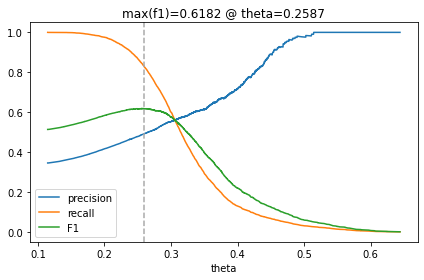

In [18]:
distances = 1 - np.array(calib_distances['distance'])
relevances = calib_distances['authorship']
precisions, recalls, thresholds = precision_recall_curve(relevances, distances, pos_label='S')
f1s = (2 * precisions * recalls) / (precisions + recalls)
f1s[np.isnan(f1s)] = 0.0

max_f1_idx = np.array(f1s).argmax()
max_f1 = f1s[max_f1_idx]
max_f1_th = thresholds[max_f1_idx]
print(f'max(f1)={round(max_f1, 4)} @ theta={round(max_f1_th, 4)}')

plt.plot(thresholds, precisions[:-1], label='precision')
plt.plot(thresholds, recalls[:-1], label='recall')
plt.plot(thresholds, f1s[:-1], label='F1')
plt.axvline(max_f1_th, ls='--', c='darkgrey')
plt.gca().set_xlabel('theta')
plt.gca().legend()
plt.title(f'max(f1)={round(max_f1, 4)} @ theta={round(max_f1_th, 4)}')
plt.tight_layout()

In [19]:
calib_thresh = 1 - max_f1_th
calib_thresh

0.7413400328409272

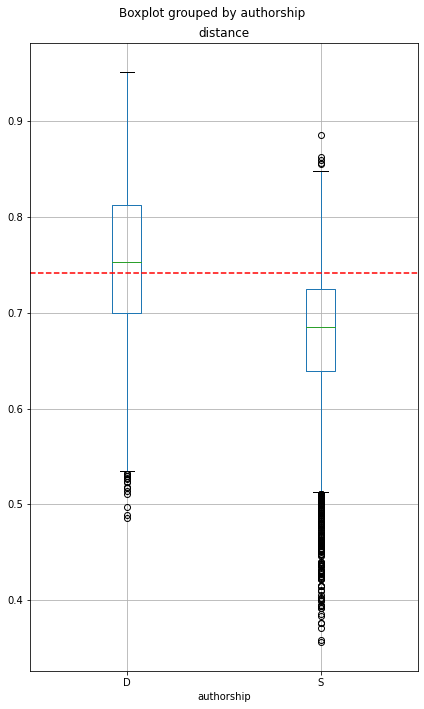

In [20]:
calib_distances.boxplot('distance', 'authorship', figsize=(6, 10))
plt.axhline(calib_thresh, c='red', ls='--')
plt.tight_layout();

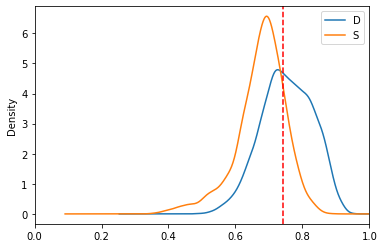

In [21]:
for grouper, group in calib_distances.groupby('authorship'):
    group['distance'].plot.kde(label=grouper);
plt.xlim((0, 1))
plt.axvline(calib_thresh, c='red', ls='--')
plt.legend();

##### Target

In [22]:
trg_df = segment_df[segment_df['title'].isin({'Limborch', 'Rose', 'Roman van Cassamus (kort)', 'Roman der Lorreinen'})]
trg_X = vectorizer.transform(trg_df['text']).toarray()
combos = pd.DataFrame(combinations(trg_df['title'].unique(), 2), columns=['title1', 'title2'])
combos['authorship'] = 'X'
combos

,title1,title2,authorship
0,Limborch,Roman der Lorreinen,X
1,Limborch,Roman van Cassamus (kort),X
2,Limborch,Rose,X
3,Roman der Lorreinen,Roman van Cassamus (kort),X
4,Roman der Lorreinen,Rose,X
5,Roman van Cassamus (kort),Rose,X


In [23]:
trg_distances = []

for idx, row in combos.iterrows():
    AX = trg_X[trg_df['title'] == row['title1']]
    BX = trg_X[trg_df['title'] == row['title2']]
    
    for distance in scidist.cdist(AX, BX, metric='cosine').flatten():
        trg_distances.append((row['title1'], row['title2'], row['authorship'], distance))

trg_distances = pd.DataFrame(trg_distances, columns=['title1', 'title2', 'authorship', 'distance'])
trg_distances

,title1,title2,authorship,distance
0,Limborch,Roman der Lorreinen,X,0.546337
1,Limborch,Roman der Lorreinen,X,0.641819
2,Limborch,Roman der Lorreinen,X,0.659370
3,Limborch,Roman der Lorreinen,X,0.583277
4,Limborch,Roman der Lorreinen,X,0.603803
...,...,...,...,...
370,Roman van Cassamus (kort),Rose,X,0.654155
371,Roman van Cassamus (kort),Rose,X,0.619768
372,Roman van Cassamus (kort),Rose,X,0.667129
373,Roman van Cassamus (kort),Rose,X,0.650481


In [24]:
distances = pd.concat([calib_distances, trg_distances])
distances

,title1,title2,authorship,distance
0,Alexanders geesten,Heymelijchede der heymelijcheit,S,0.750140
1,Alexanders geesten,Heymelijchede der heymelijcheit,S,0.787444
2,Alexanders geesten,Heymelijchede der heymelijcheit,S,0.800302
3,Alexanders geesten,Heymelijchede der heymelijcheit,S,0.786096
4,Alexanders geesten,Heymelijchede der heymelijcheit,S,0.767980
...,...,...,...,...
370,Roman van Cassamus (kort),Rose,X,0.654155
371,Roman van Cassamus (kort),Rose,X,0.619768
372,Roman van Cassamus (kort),Rose,X,0.667129
373,Roman van Cassamus (kort),Rose,X,0.650481


In [25]:
means = distances.groupby(['title1', 'title2'])['distance'].mean()
means = means.sort_values()
means.head(50)

title1                           title2                    
Brabantsche yeesten (B1-5)       Van den derden Eduwaert       0.500475
Limborch                         Roman der Lorreinen           0.508261
Spiegel historiael (P4)          Spiegel historiael (P5)       0.513878
Boec vander wraken               Jans teesteye                 0.523097
                                 Der leken spieghel            0.549933
Der leken spieghel               Jans teesteye                 0.564386
Merlijn-continuatie              Spiegel historiael (P5)       0.567054
Limborch                         Roman van Cassamus (kort)     0.568537
Roman der Lorreinen              Roman van Cassamus (kort)     0.572996
Merlijn-continuatie              Spiegel historiael (P4)       0.594576
Roman der Lorreinen              Rose                          0.596236
Boec vander wraken               Van den derden Eduwaert       0.597855
Limborch                         Rose                          0.608590
Van 

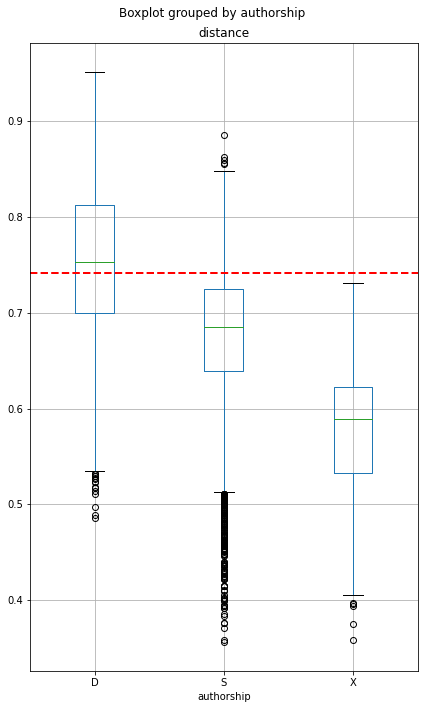

In [26]:
distances.boxplot('distance', 'authorship', figsize=(6, 10))
plt.axhline(calib_thresh, c='red', linewidth=2, ls='--')
plt.tight_layout();

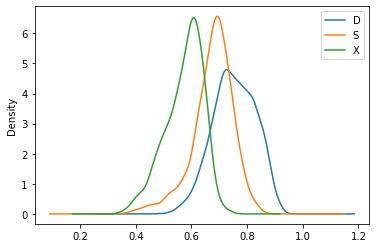

In [27]:
for grouper, group in distances.groupby('authorship'):
    group['distance'].plot.kde(label=grouper)
plt.legend();

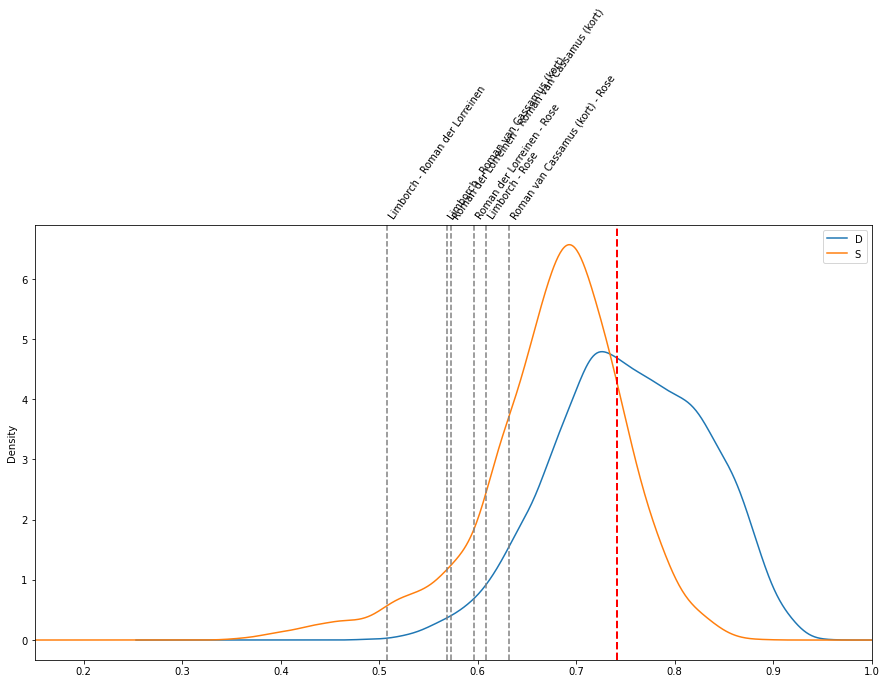

In [28]:
fig, ax = plt.subplots(figsize=(15, 8))
for grouper, group in distances.groupby('authorship'):
    if grouper == 'X':
        for m, d in group.groupby(['title1', 'title2'])['distance']:
            ax.axvline(d.mean(), c='grey', ls='--')
            plt.annotate(' - '.join(m), xy=[d.mean(), ax.get_ylim()[1]+0.1], annotation_clip=False, rotation=55)
    else:
        group['distance'].plot.kde(label=grouper, ax=ax)
plt.legend()
plt.axvline(calib_thresh, c='red', linewidth=2, ls='--')
plt.xlim(.15, 1);

## Networks

In [29]:
import re
from collections import Counter

import grapheme
import pandas as pd

import mpl_axes_aligner.align
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kendalltau
from tqdm import tqdm

from bokeh.models import HoverTool, ColumnDataSource
from bokeh.plotting import figure, show, output_file, save
from bokeh.io import output_file, show, save, output_notebook
from bokeh.plotting import figure
from bokeh.models import Axis

import seaborn as sb

from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import sklearn.preprocessing as preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

In [30]:
def scatterplot(X, df, label_column=None, color_column=None):
    if color_column:
        ints = [int(i) for i in LabelEncoder().fit_transform([str(i) for i in df[color_column]])]
        colors = sb.color_palette('husl', n_colors=len(set(ints)))
    else:
        ints = AgglomerativeClustering(n_clusters=8).fit_predict(X)
        colors = sb.color_palette('husl', n_colors=8)
    
    colors = [tuple([int(c * 256) for c in color]) for color in colors]
    
    meta_fields = ['title', 'genre', 'subgenre', 'date']
    d = {c:list(df[c]) for c in meta_fields}
    d['color'] = ['#%02x%02x%02x' % colors[i] for i in ints]
    d['x'] = X[:, 0]
    d['y'] = X[:, 1]
    d['date'] = df['date'].astype(int)
    source = ColumnDataSource(data=d)

    TOOLS="pan,wheel_zoom,reset,hover,box_select,save"

    p = figure(title='Embeddings',
               tools=TOOLS,
               plot_width=1000,
               plot_height=800,
               outline_line_color="white")

    p.circle(x='x', y='y', color='color',
             source=source, size=8,
             fill_alpha=0.9, line_color=None)
    
    if label_column:
        for label, x, y in zip(df[label_column], d['x'], d['y']):
            if isinstance(label, str):
                p.text(x, y, text=[label], text_align="center", text_font_size="6pt")

    hover = p.select(dict(type=HoverTool))
    hover.tooltips = [(c, '@'+c) for c in meta_fields]
    
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.axis.axis_line_color = None
    p.axis.major_label_text_font_size = '0pt'

    # Turn off tick marks
    p.axis.major_tick_line_color = None
    p.axis[0].ticker.num_minor_ticks = 0
    p.axis[1].ticker.num_minor_ticks = 0
    show(p)

sub_df = segment_df[segment_df['subgenre'].isin({'Arthur', 'Karel', 'Ridder', 'Allegorie', 'Dier'})]
sub_df = sub_df[~sub_df['title'].isin({'Vlaamse Rose', 'Arturs doet', 'Merlijn-continuatie', 'Queeste van den Grale', 'Lancelot'})]
vectorizer = TfidfVectorizer(**params)
BOW = vectorizer.fit_transform(sub_df['text']).toarray()
pca = PCA(n_components=15)
X = pca.fit_transform(BOW)
tsne = TSNE(n_components=2)
X = tsne.fit_transform(X)

scatterplot(X, sub_df, label_column='title', color_column='title')

In [31]:
sub_df = segment_df[segment_df['title'].isin({'Limborch', 'Rose', 'Roman van Cassamus (kort)',
                                              'Roman der Lorreinen', 'Alexanders geesten', 'Historie van Troyen',
                                              'Grimbergse oorlog', 'Rijmkroniek van Woeringen'})]
vectorizer = TfidfVectorizer(**params)
BOW = vectorizer.fit_transform(sub_df['text']).toarray()
from sklearn.preprocessing import normalize
BOW = normalize(BOW)

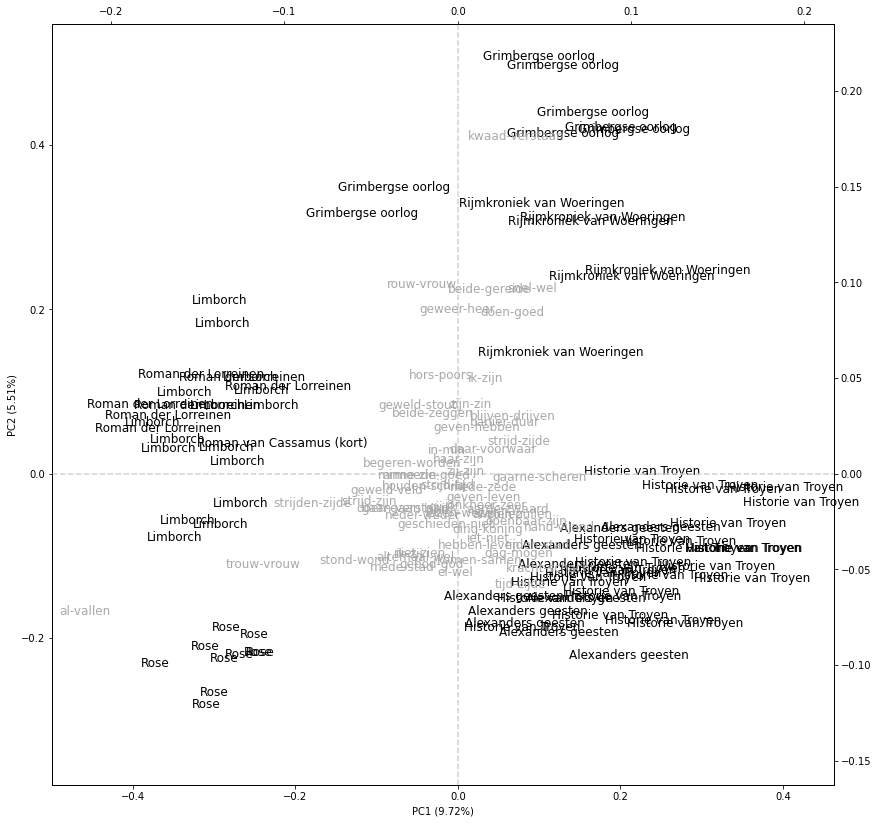

In [32]:
def plot_pca(document_proj, loadings, var_exp, labels):
    # first the texts:
    fig, text_ax = plt.subplots(figsize=(14, 14))
    x1, x2 = documents_proj[:, 0], documents_proj[:, 1]
    text_ax.scatter(x1, x2, facecolors='none')
    for p1, p2, label in zip(x1, x2, labels):
        text_ax.text(p1, p2, label, ha='center', va='center', fontsize=12)

    # add variance information to the axis labels:
    text_ax.set_xlabel(f'PC1 ({var_exp[0] * 100:.2f}%)')
    text_ax.set_ylabel(f'PC2 ({var_exp[1] * 100:.2f}%)')
    
    # now the loadings:
    loadings_ax = text_ax.twinx().twiny()
    l1, l2 = loadings[:, 0], loadings[:, 1]
    lc = l1 * l2
    m = 60
    top_idxs = lc.argsort()[::-1][:m]
    
    loadings_ax.scatter(l1[top_idxs], l2[top_idxs], facecolors='none');
    for x, y, loading in zip(l1, l2, np.array(vectorizer.get_feature_names())[top_idxs]):
        loadings_ax.text(x, y, loading, ha='center', va='center',
                         color='darkgrey', fontsize=12)

    mpl_axes_aligner.align.yaxes(text_ax, 0, loadings_ax, 0)
    mpl_axes_aligner.align.xaxes(text_ax, 0, loadings_ax, 0)
    
    # add lines through origins:
    plt.axvline(0, ls='dashed', c='lightgrey', zorder=0)
    plt.axhline(0, ls='dashed', c='lightgrey', zorder=0);

# fit the pca:
pca = PCA(n_components=2)
documents_proj = pca.fit_transform(BOW)
loadings = pca.components_.transpose()
var_exp = pca.explained_variance_ratio_

plot_pca(documents_proj, loadings, var_exp, sub_df['title'])

## Verification

In [77]:
epics = segment_df[segment_df['genre'] == 'Epiek'].copy().reindex()
epics.head(5)

,title,author,genre,date,subgenre,segment-idx,text
0,Alexanders geesten,Jacob van Maerlant,Epiek,1400.0,Ridder,1,"[zeggen, stad, horen, verdoorden, goed, doen, verstaan, waan, geraakt, maken, lof, af, verkeren, leren, goed, doen, deugd, mogen, leren, keren, verstaan, baraat, bestaan, vangen, geeste, volleesten, verstaan, slaan, roek, boek, zien, dag, beschrijven, leven, lijf, wijf, maken, geraakt, oorlog, togen, zijn, gedwaas, hebben, leven, lieden, geschieden, wind, vinden, avontuur, n(prop), n(prop), klein, spel, gevallen, hun, gestuinen, waar, jaar, dwingen, lang, toe, hoe, bestaan, goed, voren, horen, zijn, min, moeten, zoet, geslacht, macht, voren, geboren, geweld, behouden, onderdaan, ontvangen, n(prop), prijs, aardrijk, rijk, n(prop), vrij, doorvechten, kracht, helft, welk, overslaan, gaan, land, hand, schip, n(prop), jaar, waar, blijven, beschrijven, vrouw, trouw, ...]"
1,Alexanders geesten,Jacob van Maerlant,Epiek,1400.0,Ridder,2,"[n(prop), zijn, hoofd, voorhoofd, goud, oud, heer, meer, openbaar, zijn, komen, naam, waart, vaart, man, dan, geweld, houden, aardrijk, gelijk, niet, scheiden, zaal, wel, doen, moed, jooie, n(prop), voren, verkiezen, aardrijk, zekerlijk, komen, nemen, boek, doek, misdoen, goed, nieuwmaar, openbaar, land, hand, rijk, zekerlijk, vrede, stad, koninkrijk, zekerlijk, goud, geweld, onderdaan, ontvangen, dag, beliggen, rijden, tijd, horen, voren, hoog, oorlog, willen, houden, openbaar, vaar, taal, wel, gebieden, man, baroen, koen, zitten, n(prop), varen, schaar, uit, saluut, willen, houden, prijs, wijs, kroon, loon, god, bode, knecht, recht, jong, sprong, twint, kind, rijp, pijp, man, aan, n(prop), zijn, schamen, betamen, breeddelijk, zijn, ...]"
2,Alexanders geesten,Jacob van Maerlant,Epiek,1400.0,Ridder,3,"[gemoeten, onzoet, springen, dringen, paard, aarde, bede, verscheiden, ontspringen, zwang, voet, onzoet, boudewijn, zullen, n(prop), schoon, mond, stond, n(prop), n(prop), strijken, wreken, ontrijden, leed, onttreden, zijde, partij, n(prop), vervaren, varen, leven, blijven, n(prop), n(prop), vader, algader, schare, waren, zwaard, weer, zien, wagen, hoofd, kloofte, neder, weer, aldus, n(prop), stad, mede, tijd, vermijden, kracht, schacht, daad, schaden, heten, vermeten, naam, braam, doen, vlieden, n(prop), zijn, meteen, verzien, hand, zand, vlieden, doen, zwaard, vaart, waar, daar, mede, stad, daarna, n(prop), zijde, stijde, vechten, kracht, zwaard, deren, n(prop), genieten, hij, vrij, schoot, steendot, neder, weder, groot, dood, bloed, gemoeten, schacht, geslacht, geboren, voren, ...]"
3,Alexanders geesten,Jacob van Maerlant,Epiek,1400.0,Ridder,4,"[dood, n(prop), geklaag, wach, kracht, onmacht, muil, dul, verslagen, plegen, minne, in, slot, dood, doen, lelijkheid, vangen, doen, lijf, wijf, vaar, zijn, doen, waan, zeggen, stad, amie, persien, jongeling, ding, doen, spade, zee, men, wijf, lijf, zijn, n(prop), lief, hebben, bede, mede, voren, geboren, uw, doorendoor, gij, nu, rijk, gestadelijk, moed, moeten, verliezen, kiezen, ik, zijn, dat, zijn, woord, horen, lopen, roepen, zenden, n(prop), vrede, doen, vijand, zenden, willen, zullen, zeggen, vrede, tak, breken, tien, zien, zijn, n(prop), wel, taal, togen, oog, wel, el, heer, zeer, echt, recht, kind, minder, vangen, waan, zijn, mijn, bewaarden, zijn, koningin, bekennen, wijs, prijs, ...]"
4,Alexanders geesten,Jacob van Maerlant,Epiek,1400.0,Ridder,5,"[daar, openbaar, eer, nimmermeer, zeggen, allewege, mogendheid, stad, bedwang, omgang, naar, vaar, recht, lichten, stad, gerechtigheid, bij, vrij, gestade, raad, zitten, weten, zonde, stond, eenradigheid, stad, hoog, oorlog, voet, zoet, gunnen, kunnen, n(prop), na, verleden, staan, staan, waan, allewege, zeggen, n(prop), na, verzien, liggen, een, zeer, willen, behouden, vrees, reis, mogen, dunken, zaal, wel, altehand, vinden, algader, vader, liggen, verwegen, list, rusten, taal, zaal, opstaan, waan, vliegen, lachen, latijn, zijn, kracht, brengen, varen, waren, zeggen, weg, varen, waar, staan, mond, 

In [136]:
params = {'use_idf': True,
          'max_features': 5000,
          'analyzer': bigrams,
          'min_df': 2}

vectorizer = TfidfVectorizer(**params)
vectorizer.fit(epics['text'])
print(vectorizer.get_feature_names()[:30])
segment_X = vectorizer.transform(epics['text']).toarray()
segment_X.shape

['7-leven', 'aan-aan', 'aan-ban', 'aan-beginnen', 'aan-bestaan', 'aan-daar', 'aan-dag', 'aan-dan', 'aan-danen', 'aan-dat', 'aan-deze', 'aan-ding', 'aan-doen', 'aan-dood', 'aan-eer', 'aan-gaan', 'aan-gedane', 'aan-geschieden', 'aan-geven', 'aan-gewinnen', 'aan-gij', 'aan-goed', 'aan-groot', 'aan-heer', 'aan-hij', 'aan-horen', 'aan-ik', 'aan-komen', 'aan-kunnen', 'aan-land']


(526, 5000)

In [143]:
num_iter = 250
total_features = len(vectorizer.get_feature_names())
num_rnd_features = int(total_features * .5)

target_titles = ['Limborch', 'Rose', 'Roman van Cassamus (kort)', 'Roman der Lorreinen']

for target_title in target_titles:
    targets = epics[epics['title'] == target_title]
    candidates = epics[epics['title'] != target_title]
    neighbors = Counter()
    for trg_idx in tqdm(list(targets.index), desc=target_title):
        for i in range(num_iter):
            feats = np.random.choice(total_features, num_rnd_features, replace=False)
            ax = segment_X[trg_idx, feats]
            sampled = candidates.groupby('title').sample(1)
            xx = segment_X[sampled.index][:, feats]
            distances = scidist.cdist([ax], xx, metric='cosine').flatten()
            idxs = distances.argsort()[:1]
            neighbors.update(sampled.iloc[idxs]['title'])
    print(target_title, ':', neighbors.most_common(5))

Rose:   0%|          | 0/10 [00:00<?, ?it/s]

Limborch : [('Roman der Lorreinen', 2632), ('Perchevael', 303), ('Roman van Cassamus (kort)', 165), ('Rose', 143), ('Wrake van Ragisel', 119)]


Roman van Cassamus (kort):   0%|          | 0/1 [00:00<?, ?it/s]

Rose : [('Roman der Lorreinen', 698), ('Limborch', 362), ('Dietsche doctrinale', 339), ('Roman van Cassamus (kort)', 312), ('Vlaamse Rose', 204)]


Roman der Lorreinen:   0%|          | 0/7 [00:00<?, ?it/s]

Roman van Cassamus (kort) : [('Roman der Lorreinen', 79), ('Limborch', 58), ('Rose', 26), ('Enaamse Codex', 24), ('Vlaamse Rose', 14)]


Roman der Lorreinen: 100%|██████████| 7/7 [01:29<00:00, 12.73s/it]

Roman der Lorreinen : [('Limborch', 931), ('Rose', 130), ('Wrake van Ragisel', 123), ('Roman van Cassamus (kort)', 94), ('Perchevael', 93)]


### Calibration

We define a calibrator class here. It selects all same author (SA) and different author (DA) pairs:
- SA pair: all pairs of segments that are written by the same author but are not from the same text
- DA pair: all pairs of segments that are written by different authors

For every pair, the average cosine distance between the two segments is calculated by n random feature bootstraps.

In [91]:
class Calibrator():
    def __init__(self, iters=200,
                 rnd_prop=.5, random_state=1066,
                 metric='cosine',
                 rnd_state=1234):
        assert (rnd_prop >= 0.0) and (rnd_prop <= 1.0)
        
        np.random.seed(rnd_state)
        self.iters = iters
        self.rnd_prop = rnd_prop
    
    def calculate_distance(self, dev, dev_X):

        total_features = dev_X.shape[1]
        
        mean_total_DA = []
        mean_total_SA = []
        
        clustermap = np.zeros((dev_X.shape[0],  dev_X.shape[0])) # creating an array consisting of zeroes, in order to add the distances of all the iterations later on (that way, a clustermap can be created) 
        
        for it in tqdm(range(self.iters)):
            
            dev_ = dev_X

            if self.rnd_prop < 1.0: #  selecting the random proportion of features (if needed)
                idxs = np.random.choice(total_features, int(total_features * self.rnd_prop), replace=False)
                dev_ = dev_X[:, idxs]

            SA = []
            DA = []
            
            one_iter = np.zeros((dev_X.shape[0],  dev_X.shape[0])) # creating an array consisting of zeroes, in order to add the distances between texts of one iteration

            for idx_first_text,  first_text in dev.iterrows():

                for idx_second_text, second_text in dev.iterrows():

                    if (dev['author'][idx_first_text] == dev['author'][idx_second_text]) and (dev['file'][idx_first_text] != dev['file'][idx_second_text]): # same author (SA) pairs: not the same text, but the same author
                        distance = spatial.distance.cosine(dev_[idx_first_text], dev_[idx_second_text])
                        SA.append(distance)
                        
                        one_iter[idx_first_text, idx_second_text] = distance # add the distance in the right place in the array
                        
                    if (dev['author'][idx_first_text] != dev['author'][idx_second_text]): # different author (DA) pairs: not the same author
                        distance = spatial.distance.cosine(dev_[idx_first_text], dev_[idx_second_text])
                        DA.append(distance)
                        
                        one_iter[idx_first_text, idx_second_text] = distance # add the distance in the right place in the array

            clustermap = np.add(clustermap, one_iter) # add up all the distances of all the iterations

            mean_SA = sum(SA)/len(SA)
            try:
                mean_DA = sum(DA)/len(DA)
            except ZeroDivisionError: # if there are no DA pairs
                mean_DA = 0
            
            mean_total_SA.append(mean_SA)
            mean_total_DA.append(mean_DA)
            
        clustermap = np.divide(clustermap, self.iters) # divide the added up distances with the amount of iterations, in order to get the mean distance of every text pair

        return mean_total_SA, mean_total_DA, clustermap

In [44]:
calibrator = Calibrator(iters=200, rnd_prop=0.5) # 200 iterations based on 50% of the features

In [45]:
result_SA, result_DA, clustermap = calibrator.calculate_distance(dev, dev_X)
result_SA, result_DA 

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [59:45<00:00, 17.93s/it]


([0.4229029611792409,
  0.41007799801290395,
  0.44786304443404656,
  0.4940315750664176,
  0.48594671133488054,
  0.40535145567777775,
  0.41365131247138676,
  0.3820223750460448,
  0.5169771305749103,
  0.43581101271528216,
  0.40664068847560353,
  0.4892381651035153,
  0.4891901633194634,
  0.49244109341067227,
  0.37802373198415445,
  0.3621415600108246,
  0.43587653468157256,
  0.3838189246323457,
  0.44213319146046937,
  0.5015825008928364,
  0.4475561856229794,
  0.4817978982512028,
  0.3991719827644026,
  0.4080043521155683,
  0.38207805974264913,
  0.4822626267866314,
  0.39990840205620765,
  0.4369509948367899,
  0.41628720151054105,
  0.5073060888495706,
  0.5212434417325059,
  0.37725289013321534,
  0.5058651307593925,
  0.4260826573876732,
  0.4356218704427574,
  0.43542835255811946,
  0.3805607130240447,
  0.4119751003973796,
  0.3961566966525867,
  0.44388835259271014,
  0.45506377276579124,
  0.3961924515305107,
  0.5308338895709704,
  0.4000383099308079,
  0.3919382615

The average SA and DA distances:

In [46]:
avg_SA = sum(result_SA)/len(result_SA)
print(round(avg_SA, 4))
avg_DA = sum(result_DA)/len(result_DA)
print(round(avg_DA, 4))

0.4313
0.531


The median SA and DA distances:

In [47]:
import statistics
print(statistics.median(result_SA))
print(statistics.median(result_DA))

0.4264928309977989
0.5305613116022481


A boxplot with the distribution of the cosine distances between SA and DA pairs:

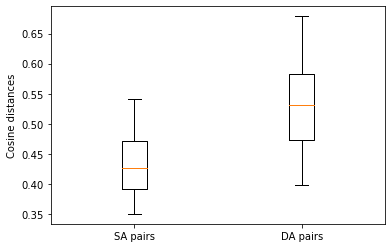

In [48]:
fig, ax = plt.subplots()
ax.boxplot([result_SA, result_DA])
ax.set(xticklabels=('SA pairs', 'DA pairs'), ylabel='Cosine distances');

Creating a clustermap of the works and their distances (https://seaborn.pydata.org/generated/seaborn.clustermap.html):

In [49]:
from scipy.spatial.distance import squareform
import scipy.cluster.hierarchy as hierarchy
import seaborn
import collections

In [50]:
cluster_frame = pd.DataFrame(data=clustermap)
cluster_frame = cluster_frame.set_index(dev['file'])
cluster_frame.set_axis(dev["file"].values.tolist(), axis=1, inplace=True)
cluster_frame

,alexanders_geesten-jacob_van_maerlant-pie,alexanders_geesten-jacob_van_maerlant-pie,alexanders_geesten-jacob_van_maerlant-pie,alexanders_geesten-jacob_van_maerlant-pie,alexanders_geesten-jacob_van_maerlant-pie,alexanders_geesten-jacob_van_maerlant-pie,alexanders_geesten-jacob_van_maerlant-pie,alexanders_geesten-jacob_van_maerlant-pie,alexanders_geesten-jacob_van_maerlant-pie,alexanders_geesten-jacob_van_maerlant-pie,...,roman_van_torec-jacob_van_maerlant-pie,roman_van_torec-jacob_van_maerlant-pie,roman_van_torec-jacob_van_maerlant-pie,roman_van_torec-jacob_van_maerlant-pie,roman_van_torec-jacob_van_maerlant-pie,roman_van_torec-jacob_van_maerlant-pie,roman_van_torec-jacob_van_maerlant-pie,roman_van_torec-jacob_van_maerlant-pie,roman_van_torec-jacob_van_maerlant-pie,roman_van_torec-jacob_van_maerlant-pie
file,,,,,,,,,,,,,,,,,,,,,
alexanders_geesten-jacob_van_maerlant-pie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.497637,0.446200,0.568191,0.481393,0.522107,0.469211,0.428786,0.531876,0.387474,0.515776
alexanders_geesten-jacob_van_maerlant-pie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.429710,0.458357,0.555695,0.495909,0.577374,0.422852,0.492608,0.481174,0.404714,0.488836
alexanders_geesten-jacob_van_maerlant-pie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.558216,0.524031,0.573221,0.582378,0.573991,0.572741,0.521689,0.588186,0.474849,0.553937
alexanders_geesten-jacob_van_maerlant-pie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.434567,0.467724,0.465282,0.426127,0.503995,0.447941,0.457439,0.458532,0.371149,0.428360
alexanders_geesten-jacob_van_maerlant-pie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.466584,0.394175,0.554460,0.444141,0.577976,0.453408,0.395159,0.532643,0.384085,0.475986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
roman_van_torec-jacob_van_maerlant-pie,0.469211,0.422852,0.572741,0.447941,0.453408,0.396168,0.529459,0.489488,0.450207,0.566536,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
roman_van_torec-jacob_van_maerlant-pie,0.428786,0.492608,0.521689,0.457439,0.395159,0.495852,0.535418,0.521164,0.496043,0.588662,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
roman_van_torec-jacob_van_maerlant-pie,0.531876,0.481174,0.588186,0.458532,0.532643,0.453067,0.522646,0.502383,0.534759,0.576698,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [51]:
def get_cluster_per_text (cluster_frame):
    
    new = cluster_frame.groupby(cluster_frame.columns, axis=1).sum() 
    new = new.groupby(cluster_frame.columns, axis=0).sum()
    
    segments = collections.Counter(cluster_frame.columns)
    
    for index, i in new.iterrows():
        for c in segments.keys():
            i[c] = i[c] / (int(segments.get(c)) * int(segments.get(index)))
                
    return new
        

In [52]:
get_cluster_per_text (cluster_frame)

,alexanders_geesten-jacob_van_maerlant-pie,floris_ende_blancefloer-dierderic_van_assenede-pie,historie_van_den_grale_en_merlijns_boec-jacob_van_maerlant-pie,historie_van_troyen-jacob_van_maerlant-pie,merlijn-continuatie-lodewijk_van_velthem-pie,roman_van_torec-jacob_van_maerlant-pie
alexanders_geesten-jacob_van_maerlant-pie,0.000000,0.465039,0.428216,0.413052,0.551395,0.482879
floris_ende_blancefloer-dierderic_van_assenede-pie,0.465039,0.000000,0.457389,0.468065,0.603587,0.520926
historie_van_den_grale_en_merlijns_boec-jacob_van_maerlant-pie,0.428216,0.457389,0.000000,0.431893,0.529424,0.451545
historie_van_troyen-jacob_van_maerlant-pie,0.413052,0.468065,0.431893,0.000000,0.552916,0.474602
merlijn-continuatie-lodewijk_van_velthem-pie,0.551395,0.603587,0.529424,0.552916,0.000000,0.315493
roman_van_torec-jacob_van_maerlant-pie,0.482879,0.520926,0.451545,0.474602,0.315493,0.000000


C:\Users\carol\anaconda3\lib\site-packages\seaborn\matrix.py:619: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


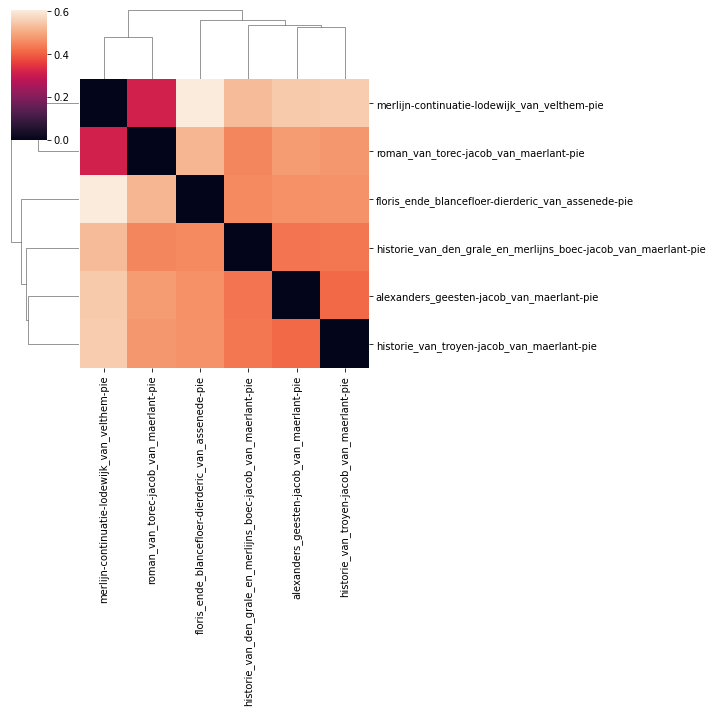

In [53]:
seaborn.clustermap(get_cluster_per_text (cluster_frame), figsize=(10,10))

In [54]:
# cluster_frame.to_csv('clustermap.csv', encoding='utf-8')

Obtaining some extra statistics (we can only do this now because of the preprocessing):

In [55]:
def get_unique_rhyme (text):
    rhyme = re.findall("\w+(?=\$\w+\(\w*\,*\w*\,*\w*\)\/)", text)
    rhyme = set(rhyme) # get the unique items of the previously obtained list
    return list(rhyme)

def number_unique_rhyme (text):
    text = set(text)
    return len(text)

def get_verse (text):
    verses = text.count("/")
    return verses

In [56]:
dev["unique_rhyme"] = dev['segments'].apply(get_unique_rhyme)
stat = dev.groupby('file').agg(sum)
stat['unique_rhyme_amount'] = stat['unique_rhyme'].apply(number_unique_rhyme)
stat

,title,author,segments,unique_rhyme,unique_rhyme_amount
file,,,,,
alexanders_geesten-jacob_van_maerlant-pie,alexanders_geesten-1alexanders_geesten-2alexan...,jacob_van_maerlantjacob_van_maerlantjacob_van_...,"het$pron(pers,3,sing) zijn$v(fin,pres,aux_cop)...","[wind, voren, minne, hoofd, verdoofd, gestade,...",1885
floris_ende_blancefloer-dierderic_van_assenede-pie,floris_ende_blancefloer-1floris_ende_blanceflo...,dierderic_van_assenededierderic_van_assenededi...,nu$adv(dem) horen$v(imp) na$adp() ik$pron(pers...,"[wind, voren, zand, minne, zee, kond, dier, we...",915
historie_van_den_grale_en_merlijns_boec-jacob_van_maerlant-pie,historie_van_den_grale_en_merlijns_boec-1histo...,jacob_van_maerlantjacob_van_maerlantjacob_van_...,al$num(indef) de$art(def) geen$pron(dem) die$p...,"[voren, graal, verdienen, hoofd, deze, gedicht...",1381
historie_van_troyen-jacob_van_maerlant-pie,historie_van_troyen-1historie_van_troyen-2hist...,jacob_van_maerlantjacob_van_maerlantjacob_van_...,deus$n(sing) achtste$misc()/ mijn$pron(poss) h...,"[opnemen, voren, hoofd, deze, geloven, tijns, ...",3250
merlijn-continuatie-lodewijk_van_velthem-pie,merlijn-1merlijn-2merlijn-3merlijn-4merlijn-5m...,lodewijk_van_velthemlodewijk_van_velthemlodewi...,god$n(sing) die$pron(rel) al$num(indef) ding$n...,"[voren, angstand, wet, verstaan, uitgeven, sin...",1605
roman_van_torec-jacob_van_maerlant-pie,roman_van_torec-1roman_van_torec-2roman_van_to...,jacob_van_maerlantjacob_van_maerlantjacob_van_...,"de$art(def) avontuur$n(sing) doen$v(fin,pres,l...","[deze, kond, verstaan, bezweren, lof, daarnaar...",794


In [57]:
dev["rhyme"] = dev['segments'].apply(get_verse)
stat = dev.groupby('file').agg(sum)
stat

,rhyme
file,
alexanders_geesten-jacob_van_maerlant-pie,14108
floris_ende_blancefloer-dierderic_van_assenede-pie,3764
historie_van_den_grale_en_merlijns_boec-jacob_van_maerlant-pie,10025
historie_van_troyen-jacob_van_maerlant-pie,40596
merlijn-continuatie-lodewijk_van_velthem-pie,25668
roman_van_torec-jacob_van_maerlant-pie,3575


## Verification (based on the previous model)

Applying the verification to the possible oeuvre of Hendrik van Brussel:

In [58]:
test_directory = 'hendrik'

test_documents, test_authors, test_titles, test_file_names = load_directory(test_directory, 1698, no_proper_names=True)
test_documents, test_authors, test_titles, test_file_names

test = {'title': test_titles, 'author': test_authors, 'file': test_file_names, 'segments': test_documents}
test = pd.DataFrame(data=test)
test

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.44it/s]


,title,author,file,segments
0,(korte)_roman_van_cassamus-1,hendrik_van_brussel,(korte)_roman_van_cassamus-hendrik_van_brussel...,X/ na$adp() die$pron(dem) dat$conj(subord) de$...
1,(korte)_roman_van_cassamus-2,hendrik_van_brussel,(korte)_roman_van_cassamus-hendrik_van_brussel...,op$adp() een$art(indef) rivier$n(sing)/ en$con...
2,(korte)_roman_van_cassamus-3,hendrik_van_brussel,(korte)_roman_van_cassamus-hendrik_van_brussel...,"negeen$pron(indef) ontzeggen$v(fin,past,lex)/ ..."
3,(korte)_roman_van_cassamus-4,hendrik_van_brussel,(korte)_roman_van_cassamus-hendrik_van_brussel...,"te+wij+waart$adp()+pron(pers,1,plu)+adp() kome..."
4,(korte)_roman_van_cassamus-5,hendrik_van_brussel,(korte)_roman_van_cassamus-hendrik_van_brussel...,kracht$n(sing) daar$pronadv(dem) mede$pronadv(...
...,...,...,...,...
125,roman_van_limborch-69,hendrik_van_brussel,roman_van_limborch-hendrik_van_brussel-pie,"ik$pron(pers,1,sing) mogen$v(fin,pres,aux_cop)..."
126,roman_van_limborch-70,hendrik_van_brussel,roman_van_limborch-hendrik_van_brussel-pie,de$art(def) weg$n(sing) iet$pron(indef) togen$...
127,roman_van_limborch-71,hendrik_van_brussel,roman_van_limborch-hendrik_van_brussel-pie,"groot$adj() plein$n(sing) zij$pron(pers,3,plu)..."
128,roman_van_limborch-72,hendrik_van_brussel,roman_van_limborch-hendrik_van_brussel-pie,"komen$v(participle,pres) verzien$v(infin)/ en$..."


Obtaining the amount of segments for each text:

In [59]:
for file in test['file'].unique():
    print(file)
    print(len(test[test["file"] == file]))

(korte)_roman_van_cassamus-hendrik_van_brussel-pie
6
die_rose-hendrik_van_brussel-pie
50
hughen_van_tabaryen-hendrik_van_brussel-pie
1
roman_van_limborch-hendrik_van_brussel-pie
73


In [60]:
test_X = rhyme_vectorizer.transform(test['segments']).toarray() # use the fitted vectorizer

test_result_SA, test_result_DA, test_clustermap = calibrator.calculate_distance(test, test_X) # use the calibrator defined previously
test_result_SA, test_result_DA

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [07:44<00:00,  2.32s/it]


([0.33140329002845376,
  0.3210957443171834,
  0.39391281928227523,
  0.37480680023684493,
  0.4337540230362498,
  0.40649415509031533,
  0.33750981231358884,
  0.4504988446116207,
  0.47237178735306073,
  0.45902884812429284,
  0.3918709602267381,
  0.32051868248026816,
  0.37605110189462443,
  0.3582426138078829,
  0.31250597221400706,
  0.3189242515680929,
  0.4699548400973923,
  0.4535313214824039,
  0.3737381586044102,
  0.32300366492243066,
  0.3723646136199621,
  0.37862123813190657,
  0.387919167462171,
  0.37356517226582797,
  0.3550943813962653,
  0.37837818985130234,
  0.4236336532633821,
  0.3889982332752915,
  0.3759457587159804,
  0.3238007381783262,
  0.32845155317713126,
  0.3828944091662325,
  0.35518981780538256,
  0.43059892653142,
  0.4046061472685658,
  0.4611664030972294,
  0.32619226359454073,
  0.35450889441096173,
  0.35115063621133985,
  0.36337028299435586,
  0.36501568333141704,
  0.37307469786840597,
  0.47678179589441644,
  0.36805384054682855,
  0.4242684

The average distances (we want to examine whether the works were written by the same author, so we only calculate one value now. Do not mind the names of the variables):

In [61]:
test_avg_SA = sum(test_result_SA)/len(test_result_SA)
print(round(test_avg_SA, 4))
test_avg_DA = sum(test_result_DA)/len(test_result_DA)
print(round(test_avg_DA, 4))

0.3774
0.0


The median distances:

In [62]:
print(statistics.median(test_result_SA))
print(statistics.median(result_SA))
print(statistics.median(result_DA))

0.372645239280544
0.4264928309977989
0.5305613116022481


A boxplot with the distribution of the cosine distances:

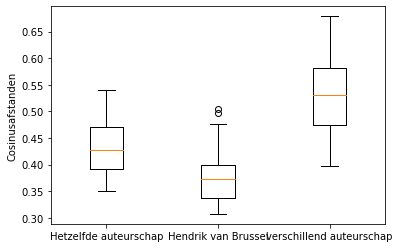

In [63]:
fig, ax = plt.subplots()
ax.boxplot([result_SA, test_result_SA, result_DA])
ax.set(xticklabels=('Hetzelfde auteurschap', 'Hendrik van Brussel', 'verschillend auteurschap'), ylabel='Cosinusafstanden');

Creating a clustermap of the works and their distances. 

In [64]:
test_cluster_frame = pd.DataFrame(data=test_clustermap)
test_cluster_frame = test_cluster_frame.set_index(test['file'])
test_cluster_frame.set_axis(test["file"].values.tolist(), axis=1, inplace=True)
test_cluster_frame

,(korte)_roman_van_cassamus-hendrik_van_brussel-pie,(korte)_roman_van_cassamus-hendrik_van_brussel-pie,(korte)_roman_van_cassamus-hendrik_van_brussel-pie,(korte)_roman_van_cassamus-hendrik_van_brussel-pie,(korte)_roman_van_cassamus-hendrik_van_brussel-pie,(korte)_roman_van_cassamus-hendrik_van_brussel-pie,die_rose-hendrik_van_brussel-pie,die_rose-hendrik_van_brussel-pie,die_rose-hendrik_van_brussel-pie,die_rose-hendrik_van_brussel-pie,...,roman_van_limborch-hendrik_van_brussel-pie,roman_van_limborch-hendrik_van_brussel-pie,roman_van_limborch-hendrik_van_brussel-pie,roman_van_limborch-hendrik_van_brussel-pie,roman_van_limborch-hendrik_van_brussel-pie,roman_van_limborch-hendrik_van_brussel-pie,roman_van_limborch-hendrik_van_brussel-pie,roman_van_limborch-hendrik_van_brussel-pie,roman_van_limborch-hendrik_van_brussel-pie,roman_van_limborch-hendrik_van_brussel-pie
file,,,,,,,,,,,,,,,,,,,,,
(korte)_roman_van_cassamus-hendrik_van_brussel-pie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.448269,0.583178,0.414832,0.361953,...,0.397368,0.356448,0.467805,0.436473,0.517415,0.373375,0.373725,0.380684,0.442884,0.441932
(korte)_roman_van_cassamus-hendrik_van_brussel-pie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.399550,0.464597,0.365083,0.450338,...,0.296660,0.346659,0.324878,0.382851,0.423445,0.289743,0.261028,0.261667,0.329337,0.376015
(korte)_roman_van_cassamus-hendrik_van_brussel-pie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.455675,0.466874,0.411867,0.404752,...,0.292924,0.389894,0.350940,0.439056,0.473856,0.380838,0.343984,0.176404,0.363623,0.396971
(korte)_roman_van_cassamus-hendrik_van_brussel-pie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.534585,0.609003,0.419088,0.422991,...,0.342471,0.422501,0.445889,0.414886,0.512168,0.424636,0.287017,0.246696,0.415870,0.452980
(korte)_roman_van_cassamus-hendrik_van_brussel-pie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.349795,0.335637,0.307403,0.383234,...,0.339647,0.476408,0.392378,0.348488,0.385294,0.384367,0.435848,0.396103,0.388073,0.268427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
roman_van_limborch-hendrik_van_brussel-pie,0.373375,0.289743,0.380838,0.424636,0.384367,0.427822,0.407913,0.389234,0.305913,0.477045,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
roman_van_limborch-hendrik_van_brussel-pie,0.373725,0.261028,0.343984,0.287017,0.435848,0.493038,0.413384,0.461692,0.308027,0.529275,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
roman_van_limborch-hendrik_van_brussel-pie,0.380684,0.261667,0.176404,0.246696,0.396103,0.464032,0.446789,0.469823,0.367130,0.513077,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


C:\Users\carol\anaconda3\lib\site-packages\seaborn\matrix.py:619: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


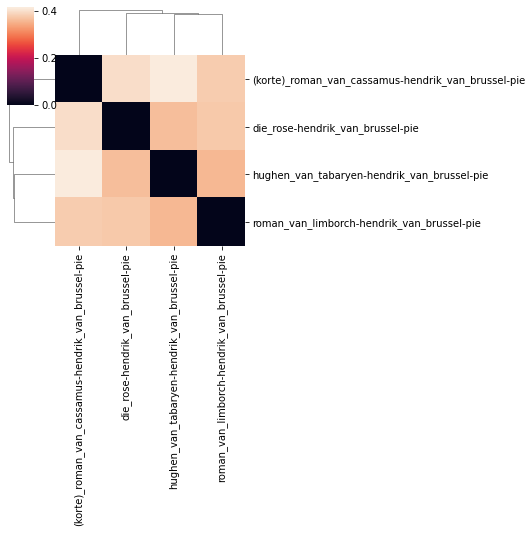

In [65]:
seaborn.clustermap(get_cluster_per_text(test_cluster_frame), figsize=(7.5, 7.5))

Obtaining some extra statistics (we can only do this now because of the preprocessing):

In [66]:
test["unique_rhyme"] = test['segments'].apply(get_unique_rhyme)
stat = test.groupby('file').agg(sum)
stat['unique_rhyme_amount'] = stat['unique_rhyme'].apply(number_unique_rhyme)
stat

,title,author,segments,unique_rhyme,unique_rhyme_amount
file,,,,,
(korte)_roman_van_cassamus-hendrik_van_brussel-pie,(korte)_roman_van_cassamus-1(korte)_roman_van_...,hendrik_van_brusselhendrik_van_brusselhendrik_...,X/ na$adp() die$pron(dem) dat$conj(subord) de$...,"[voren, emminoda, pond, wijs, jongeling, sprek...",569
die_rose-hendrik_van_brussel-pie,die_rose-1die_rose-2die_rose-3die_rose-4die_ro...,hendrik_van_brusselhendrik_van_brusselhendrik_...,"het$pron(pers,3,sing) zeggen$v(fin,pres,lex) m...","[voren, minne, bekommert, verstaan, ie, naaldj...",2085
hughen_van_tabaryen-hendrik_van_brussel-pie,hughen_van_tabaryen-1,hendrik_van_brussel,"het$pron(pers,3,sing) doen$v(fin,pres,aux_cop)...","[voren, nimmee, deze, wee, verstaan, bezweren,...",198
roman_van_limborch-hendrik_van_brussel-pie,roman_van_limborch-1roman_van_limborch-2roman_...,hendrik_van_brusselhendrik_van_brusselhendrik_...,ootmoedig$adj() god$n(sing) geweldig$adj() hee...,"[voren, noemen, schoonheid, verblijden, dier, ...",2084


In [67]:
test["rhyme"] = test['segments'].apply(get_verse)
stat = test.groupby('file').agg(sum)
stat

,rhyme
file,
(korte)_roman_van_cassamus-hendrik_van_brussel-pie,1724
die_rose-hendrik_van_brussel-pie,14132
hughen_van_tabaryen-hendrik_van_brussel-pie,272
roman_van_limborch-hendrik_van_brussel-pie,21660


## Calibration for "historische kronieken" (chronicles)

Loading in the calibration corpus:

In [68]:
documents, authors, titles, file_names = load_directory('spiegel_historiael', 1698, no_proper_names=True)
authors, titles, file_names

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.79it/s]


(['jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van_boendale',
  'jan_van

In [69]:
titles[38]

'brabantsche_yeesten__1-39'

In [70]:
documents[38]

'vallen$v(fin,past,lex) dat$pron(dem) wel$adv(gener) op$adp() haar$pron(poss) hoede$n(sing)/ dat$conj(subord) de$art(def) hertog$n(sing) in$adp() erre$adj() moed$n(sing)/ te$adp() haastelijk$adv(gener) mogen$v(fin,past,aux_cop) recht$v(infin) gaan$v(infin)/ als$conj(comp) hij$pron(pers,3,sing) te$adp() voor$adv(gener) hebben$v(fin,past,aux_cop) doen$v(participle,past)/ antwerpen$n(sing) te$adp() daar$adv(rel) men$pron(indef) lieden$n(plu) nemen$v(fin,past,lex) het$art(def) leven$n(sing)/ dat$pron(dem) beter$adj() zijn$v(fin,past,aux_cop) achter$adv(gener) blijven$v(participle,past)/ en$conj(coord) slot$n(plu) haar$pron(poss) poort$n(plu) te$pronadv(pers)/ jegen$adp() de$art(def) hertog$n(sing) en$conj(coord) de$art(def) zijn$pron(poss) toen$adv(dem)/ de$art(def) hertog$n(sing) worden$v(fin,past,aux_cop) gram$adj() hier$pronadv(dem) om$pronadv(prep)/ en$conj(coord) beliggen$v(fin,past,lex) de$art(def) stad$n(sing) al$adv(gener) om$adp()/ en$conj(coord) steken$v(fin,past,lex) in$adp() de

Creating a data frame with all of the information regarding the text segments:

In [71]:
dev = {'title': titles, 'author': authors, 'file': file_names, 'segments': documents}
dev = pd.DataFrame(data=dev)
dev

,title,author,file,segments
0,brabantsche_yeesten__1-1,jan_van_boendale,brabantsche_yeesten__1-5-jan_van_boendale-pie,om$adp() dat$pron(dem) van$adp() X de$art(def)...
1,brabantsche_yeesten__1-2,jan_van_boendale,brabantsche_yeesten__1-5-jan_van_boendale-pie,in$adp() de$art(def) woud$n(sing)/ kluizenaar$...
2,brabantsche_yeesten__1-3,jan_van_boendale,brabantsche_yeesten__1-5-jan_van_boendale-pie,mede$adv(gener) ander$adj() lieden$n(plu)/ de$...
3,brabantsche_yeesten__1-4,jan_van_boendale,brabantsche_yeesten__1-5-jan_van_boendale-pie,"hij$pron(pers,3,sing) in$adp() de$art(def) eer..."
4,brabantsche_yeesten__1-5,jan_van_boendale,brabantsche_yeesten__1-5-jan_van_boendale-pie,"zijn$v(fin,past,aux_cop) worden$v(participle,p..."
...,...,...,...,...
622,spiegel_historiael__5-62,lodewijk_van_velthem,spiegel_historiael__5-lodewijk_van_velthem-pie,"om$adp() hij$pron(pers,3,sing) daar$adv(dem) t..."
623,spiegel_historiael__5-63,lodewijk_van_velthem,spiegel_historiael__5-lodewijk_van_velthem-pie,"doen$conj(subord) zij$pron(pers,3,plu) en$conj..."
624,spiegel_historiael__5-64,lodewijk_van_velthem,spiegel_historiael__5-lodewijk_van_velthem-pie,zo$adv(resum) van$adp() al$num(indef) ander$ad...
625,spiegel_historiael__5-65,lodewijk_van_velthem,spiegel_historiael__5-lodewijk_van_velthem-pie,"ik$pron(pers,1,sing) zoeken$v(fin,past,lex) uw..."


Obtaining the amount of segments:

In [72]:
for file in dev['file'].unique():
    print(file)
    print(len(dev[dev["file"] == file]))

brabantsche_yeesten__1-5-jan_van_boendale-pie
53
der_leken_spieghel-jan_van_boendale-pie
71
spiegel_historiael__1-jacob_van_maerlant-pie
106
spiegel_historiael__2-philip_utenbroeke-pie
117
spiegel_historiael__3_4-jacob_van_maerlant-pie
191
spiegel_historiael__4-lodewijk_van_velthem-pie 
23
spiegel_historiael__5-lodewijk_van_velthem-pie
66


Features for the vectorizer:

In [73]:
rhyme_words = {'use_idf': True,
          'max_features': 100,
          'analyzer': 'word',
          'token_pattern': r"\w+(?=\$\w+\(\w*\,*\w*\,*\w*\)\/)",
#           'min_df': 2,
          'norm': 'l1',
          'ngram_range': (1, 1)}

In [74]:
rhyme_vectorizer = TfidfVectorizer(**rhyme_words)

Fitting and tranforming:

In [75]:
dev_X = rhyme_vectorizer.fit_transform(dev['segments']).toarray()

The number of segments in the first spot and the amount of features in the second spot:

In [76]:
dev_X.shape

(627, 100)

Using the "Calibrator":

In [77]:
calibrator = Calibrator(iters=200, rnd_prop=0.5) # 200 iterations based on 50% of the features

In [78]:
result_SA, result_DA, clustermap = calibrator.calculate_distance(dev, dev_X)
result_SA, result_DA 

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [3:06:08<00:00, 55.84s/it]


([0.3944279402889042,
  0.3933877171513391,
  0.3960938498963952,
  0.42010838256307914,
  0.38330847502701765,
  0.4369588143419768,
  0.38842290960149345,
  0.4148423842056852,
  0.5140593563358762,
  0.39353787434074905,
  0.420646656666018,
  0.42516268129304363,
  0.4874711634171582,
  0.4846423922102706,
  0.4244982499754944,
  0.43033328327268927,
  0.4207114427148077,
  0.4150524999894643,
  0.4029449715282014,
  0.4706560468330701,
  0.4739636834703964,
  0.4503274483211488,
  0.47679820114879035,
  0.47516132616358625,
  0.4102530408260765,
  0.380842917679132,
  0.4731562754531294,
  0.48864900045381027,
  0.45007092327784765,
  0.4008362092660867,
  0.4125667166501433,
  0.4868297634602733,
  0.37755180506187674,
  0.440154520334872,
  0.4130118958739349,
  0.45347171721168134,
  0.4607746935802404,
  0.3940959605165671,
  0.4152030530235193,
  0.463576321087379,
  0.4109717994873893,
  0.4444055119053339,
  0.38275099305332483,
  0.4117676477808852,
  0.42192147085171156,


The average SA and DA distances:

In [79]:
avg_SA = sum(result_SA)/len(result_SA)
print(round(avg_SA, 4))
avg_DA = sum(result_DA)/len(result_DA)
print(round(avg_DA, 4))

0.4352
0.455


The median SA and DA distances:

In [80]:
print(statistics.median(result_SA))
print(statistics.median(result_DA))

0.4289093933952588
0.44570773677566733


A boxplot with the distribution of the cosine distances between SA and DA pairs:

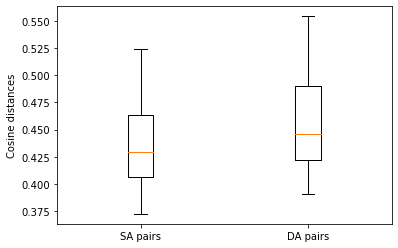

In [81]:
fig, ax = plt.subplots()
ax.boxplot([result_SA, result_DA])
ax.set(xticklabels=('SA pairs', 'DA pairs'), ylabel='Cosine distances');

Creating a clustermap of the works and their distances:

In [82]:
cluster_frame = pd.DataFrame(data=clustermap)
cluster_frame = cluster_frame.set_index(dev['file'])
cluster_frame.set_axis(dev["file"].values.tolist(), axis=1, inplace=True)
cluster_frame

,brabantsche_yeesten__1-5-jan_van_boendale-pie,brabantsche_yeesten__1-5-jan_van_boendale-pie,brabantsche_yeesten__1-5-jan_van_boendale-pie,brabantsche_yeesten__1-5-jan_van_boendale-pie,brabantsche_yeesten__1-5-jan_van_boendale-pie,brabantsche_yeesten__1-5-jan_van_boendale-pie,brabantsche_yeesten__1-5-jan_van_boendale-pie,brabantsche_yeesten__1-5-jan_van_boendale-pie,brabantsche_yeesten__1-5-jan_van_boendale-pie,brabantsche_yeesten__1-5-jan_van_boendale-pie,...,spiegel_historiael__5-lodewijk_van_velthem-pie,spiegel_historiael__5-lodewijk_van_velthem-pie,spiegel_historiael__5-lodewijk_van_velthem-pie,spiegel_historiael__5-lodewijk_van_velthem-pie,spiegel_historiael__5-lodewijk_van_velthem-pie,spiegel_historiael__5-lodewijk_van_velthem-pie,spiegel_historiael__5-lodewijk_van_velthem-pie,spiegel_historiael__5-lodewijk_van_velthem-pie,spiegel_historiael__5-lodewijk_van_velthem-pie,spiegel_historiael__5-lodewijk_van_velthem-pie
file,,,,,,,,,,,,,,,,,,,,,
brabantsche_yeesten__1-5-jan_van_boendale-pie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.388936,0.373396,0.413503,0.436305,0.381198,0.422145,0.460868,0.424299,0.447864,0.357112
brabantsche_yeesten__1-5-jan_van_boendale-pie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.492997,0.495894,0.542573,0.456481,0.508300,0.474251,0.542253,0.538622,0.543457,0.464761
brabantsche_yeesten__1-5-jan_van_boendale-pie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.523080,0.483018,0.489920,0.472191,0.598776,0.534466,0.564339,0.550996,0.541881,0.520421
brabantsche_yeesten__1-5-jan_van_boendale-pie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.522549,0.453546,0.449281,0.456396,0.486492,0.507660,0.526861,0.486270,0.537633,0.457065
brabantsche_yeesten__1-5-jan_van_boendale-pie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.469027,0.450896,0.507595,0.500341,0.519513,0.558715,0.592691,0.567569,0.605360,0.493026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
spiegel_historiael__5-lodewijk_van_velthem-pie,0.422145,0.474251,0.534466,0.507660,0.558715,0.480566,0.404966,0.470761,0.510749,0.560561,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
spiegel_historiael__5-lodewijk_van_velthem-pie,0.460868,0.542253,0.564339,0.526861,0.592691,0.525949,0.484978,0.524769,0.536137,0.611428,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
spiegel_historiael__5-lodewijk_van_velthem-pie,0.424299,0.538622,0.550996,0.486270,0.567569,0.463254,0.460767,0.475555,0.434029,0.558383,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [83]:
get_cluster_per_text (cluster_frame)

,brabantsche_yeesten__1-5-jan_van_boendale-pie,der_leken_spieghel-jan_van_boendale-pie,spiegel_historiael__1-jacob_van_maerlant-pie,spiegel_historiael__2-philip_utenbroeke-pie,spiegel_historiael__3_4-jacob_van_maerlant-pie,spiegel_historiael__4-lodewijk_van_velthem-pie,spiegel_historiael__5-lodewijk_van_velthem-pie
brabantsche_yeesten__1-5-jan_van_boendale-pie,0.000000,0.450915,0.431200,0.441493,0.415294,0.457557,0.462338
der_leken_spieghel-jan_van_boendale-pie,0.450915,0.000000,0.460356,0.430082,0.474754,0.458045,0.457798
spiegel_historiael__1-jacob_van_maerlant-pie,0.431200,0.460356,0.000000,0.451055,0.435081,0.461694,0.478946
spiegel_historiael__2-philip_utenbroeke-pie,0.441493,0.430082,0.451055,0.000000,0.451730,0.445285,0.453396
spiegel_historiael__3_4-jacob_van_maerlant-pie,0.415294,0.474754,0.435081,0.451730,0.000000,0.467370,0.486711
spiegel_historiael__4-lodewijk_van_velthem-pie,0.457557,0.458045,0.461694,0.445285,0.467370,0.000000,0.397848
spiegel_historiael__5-lodewijk_van_velthem-pie,0.462338,0.457798,0.478946,0.453396,0.486711,0.397848,0.000000


C:\Users\carol\anaconda3\lib\site-packages\seaborn\matrix.py:619: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


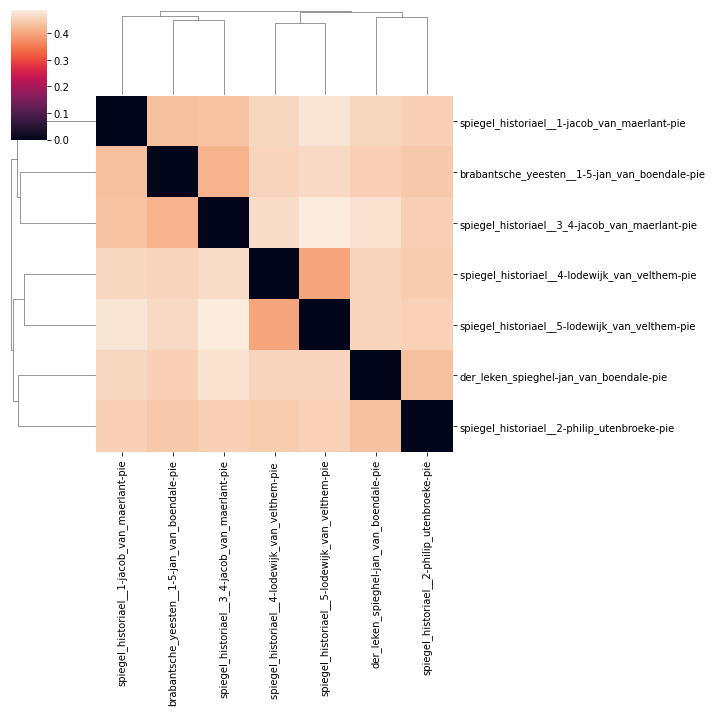

In [84]:
seaborn.clustermap(get_cluster_per_text (cluster_frame), figsize=(10,10))

Obtaining extra statistics again:

In [85]:
dev["unique_rhyme"] = dev['segments'].apply(get_unique_rhyme)
stat = dev.groupby('file').agg(sum)
stat['unique_rhyme_amount'] = stat['unique_rhyme'].apply(number_unique_rhyme)
stat

,title,author,segments,unique_rhyme,unique_rhyme_amount
file,,,,,
brabantsche_yeesten__1-5-jan_van_boendale-pie,brabantsche_yeesten__1-1brabantsche_yeesten__1...,jan_van_boendalejan_van_boendalejan_van_boenda...,om$adp() dat$pron(dem) van$adp() X de$art(def)...,"[voren, verstaan, geest, wijs, begin, danken, ...",1860
der_leken_spieghel-jan_van_boendale-pie,der_leken_spieghel-1der_leken_spieghel-2der_le...,jan_van_boendalejan_van_boendalejan_van_boenda...,"omdat$conj(subord) ik$pron(pers,1,sing) niet$a...","[zee, ledigheid, 27, wet, verstaan, lof, 6, da...",2344
spiegel_historiael__1-jacob_van_maerlant-pie,spiegel_historiael__1-1spiegel_historiael__1-2...,jacob_van_maerlantjacob_van_maerlantjacob_van_...,de$art(def) eerst$num(ord) boek$n(sing) nemen$...,"[wijl, 27, wet, 6, vier, begin, twaalf, 13, tw...",2798
spiegel_historiael__2-philip_utenbroeke-pie,spiegel_historiael__2-1spiegel_historiael__2-2...,philip_utenbroekephilip_utenbroekephilip_utenb...,de$art(def) eerst$num(ord) boek$n(sing) die$pr...,"[voren, victorie, deze, 52, 76, kond, ledighei...",2812
spiegel_historiael__3_4-jacob_van_maerlant-pie,spiegel_historiael__3_4-1spiegel_historiael__3...,jacob_van_maerlantjacob_van_maerlantjacob_van_...,"nu$adv(dem) gaan$v(fin,pres,lex) de$art(def) d...","[noemen, deze, aannemen, 27, verstaan, 6, begi...",3637
spiegel_historiael__4-lodewijk_van_velthem-pie,spiegel_historiael__4-1spiegel_historiael__4-2...,lodewijk_van_velthemlodewijk_van_velthemlodewi...,dat$pron(dem) in$adp() raad$n(sing) toen$adv(d...,"[voren, deze, kond, verstaan, gezel, voor, wee...",1396
spiegel_historiael__5-lodewijk_van_velthem-pie,spiegel_historiael__5-1spiegel_historiael__5-2...,lodewijk_van_velthemlodewijk_van_velthemlodewi...,de$art(def) vader$n(sing) die$pron(rel) al$adv...,"[voren, zee, noemen, gedicht, onder, beschiete...",2070


In [86]:
dev["rhyme"] = dev['segments'].apply(get_verse)
stat = dev.groupby('file').agg(sum)
stat

,rhyme
file,
brabantsche_yeesten__1-5-jan_van_boendale-pie,16111
der_leken_spieghel-jan_van_boendale-pie,21823
spiegel_historiael__1-jacob_van_maerlant-pie,31966
spiegel_historiael__2-philip_utenbroeke-pie,34472
spiegel_historiael__3_4-jacob_van_maerlant-pie,57732
spiegel_historiael__4-lodewijk_van_velthem-pie,6667
spiegel_historiael__5-lodewijk_van_velthem-pie,19034


## Verification (based on the previous model)

Applying the verification to the possible oeuvre of Hendrik van Brussel:

In [87]:
test_directory = 'hendrik'

test_documents, test_authors, test_titles, test_file_names = load_directory(test_directory, 1698, no_proper_names=True)
test_documents, test_authors, test_titles, test_file_names

test = {'title': test_titles, 'author': test_authors, 'file': test_file_names, 'segments': test_documents}
test = pd.DataFrame(data=test)
test

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.04it/s]


,title,author,file,segments
0,(korte)_roman_van_cassamus-1,hendrik_van_brussel,(korte)_roman_van_cassamus-hendrik_van_brussel...,X/ na$adp() die$pron(dem) dat$conj(subord) de$...
1,(korte)_roman_van_cassamus-2,hendrik_van_brussel,(korte)_roman_van_cassamus-hendrik_van_brussel...,op$adp() een$art(indef) rivier$n(sing)/ en$con...
2,(korte)_roman_van_cassamus-3,hendrik_van_brussel,(korte)_roman_van_cassamus-hendrik_van_brussel...,"negeen$pron(indef) ontzeggen$v(fin,past,lex)/ ..."
3,(korte)_roman_van_cassamus-4,hendrik_van_brussel,(korte)_roman_van_cassamus-hendrik_van_brussel...,"te+wij+waart$adp()+pron(pers,1,plu)+adp() kome..."
4,(korte)_roman_van_cassamus-5,hendrik_van_brussel,(korte)_roman_van_cassamus-hendrik_van_brussel...,kracht$n(sing) daar$pronadv(dem) mede$pronadv(...
...,...,...,...,...
125,roman_van_limborch-69,hendrik_van_brussel,roman_van_limborch-hendrik_van_brussel-pie,"ik$pron(pers,1,sing) mogen$v(fin,pres,aux_cop)..."
126,roman_van_limborch-70,hendrik_van_brussel,roman_van_limborch-hendrik_van_brussel-pie,de$art(def) weg$n(sing) iet$pron(indef) togen$...
127,roman_van_limborch-71,hendrik_van_brussel,roman_van_limborch-hendrik_van_brussel-pie,"groot$adj() plein$n(sing) zij$pron(pers,3,plu)..."
128,roman_van_limborch-72,hendrik_van_brussel,roman_van_limborch-hendrik_van_brussel-pie,"komen$v(participle,pres) verzien$v(infin)/ en$..."


In [88]:
test_X = rhyme_vectorizer.transform(test['segments']).toarray() # use the fitted vectorizer

test_result_SA, test_result_DA, test_clustermap = calibrator.calculate_distance(test, test_X) # use the calibrator defined previously
test_result_SA, test_result_DA

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [07:42<00:00,  2.31s/it]


([0.4359469039357283,
  0.3836922648108763,
  0.39188015037937074,
  0.4382272012616016,
  0.4835749793468371,
  0.41702152174013524,
  0.4080073133765303,
  0.3839940763512378,
  0.4484164963326976,
  0.46468156395624205,
  0.44370360667044595,
  0.4231897558923994,
  0.4250693088885044,
  0.40097671411099756,
  0.3953844680234757,
  0.4209869874713878,
  0.4756735427570025,
  0.3540822548505033,
  0.4217969636676008,
  0.3928613573189234,
  0.38909408325256395,
  0.47897511268773446,
  0.4465111432823443,
  0.40749044712522814,
  0.44253043864111924,
  0.4195528713955622,
  0.42592132020566803,
  0.37000998747887953,
  0.42167067339015546,
  0.42515291821602885,
  0.3970025492429592,
  0.4442690882575307,
  0.409532012869398,
  0.4432748727912312,
  0.516708426856377,
  0.3750769786894301,
  0.41352788820812836,
  0.4061498048717818,
  0.3972506601542522,
  0.42255534623419844,
  0.38525835397762603,
  0.42058680395683884,
  0.48407648815842774,
  0.47639970703417384,
  0.40331853275

The average distances (we want to examine whether the works were written by the same author, so we only calculate one value now. Do not mind the names of the variables):

In [89]:
test_avg_SA = sum(test_result_SA)/len(test_result_SA)
print(round(test_avg_SA, 4))
test_avg_DA = sum(test_result_DA)/len(test_result_DA)
print(round(test_avg_DA, 4))

0.4197
0.0


The median distances:

In [90]:
print(statistics.median(test_result_SA))
print(statistics.median(result_SA))
print(statistics.median(result_DA))

0.41698983443885473
0.4289093933952588
0.44570773677566733


A boxplot with the distribution of the cosine distances:

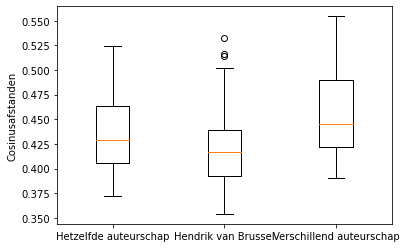

In [91]:
fig, ax = plt.subplots()
ax.boxplot([result_SA, test_result_SA, result_DA])
ax.set(xticklabels=('Hetzelfde auteurschap', 'Hendrik van Brussel', 'Verschillend auteurschap'), ylabel='Cosinusafstanden');

Creating a clustermap of the works and their distances:

In [92]:
test_cluster_frame = pd.DataFrame(data=test_clustermap)
test_cluster_frame = test_cluster_frame.set_index(test['file'])
test_cluster_frame.set_axis(test["file"].values.tolist(), axis=1, inplace=True)
test_cluster_frame

,(korte)_roman_van_cassamus-hendrik_van_brussel-pie,(korte)_roman_van_cassamus-hendrik_van_brussel-pie,(korte)_roman_van_cassamus-hendrik_van_brussel-pie,(korte)_roman_van_cassamus-hendrik_van_brussel-pie,(korte)_roman_van_cassamus-hendrik_van_brussel-pie,(korte)_roman_van_cassamus-hendrik_van_brussel-pie,die_rose-hendrik_van_brussel-pie,die_rose-hendrik_van_brussel-pie,die_rose-hendrik_van_brussel-pie,die_rose-hendrik_van_brussel-pie,...,roman_van_limborch-hendrik_van_brussel-pie,roman_van_limborch-hendrik_van_brussel-pie,roman_van_limborch-hendrik_van_brussel-pie,roman_van_limborch-hendrik_van_brussel-pie,roman_van_limborch-hendrik_van_brussel-pie,roman_van_limborch-hendrik_van_brussel-pie,roman_van_limborch-hendrik_van_brussel-pie,roman_van_limborch-hendrik_van_brussel-pie,roman_van_limborch-hendrik_van_brussel-pie,roman_van_limborch-hendrik_van_brussel-pie
file,,,,,,,,,,,,,,,,,,,,,
(korte)_roman_van_cassamus-hendrik_van_brussel-pie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.489780,0.564651,0.460577,0.368978,...,0.456589,0.402406,0.494489,0.493820,0.519383,0.405688,0.470009,0.429278,0.450212,0.531544
(korte)_roman_van_cassamus-hendrik_van_brussel-pie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.466778,0.489643,0.447407,0.477723,...,0.351473,0.372258,0.404752,0.514312,0.498157,0.294774,0.278440,0.346312,0.370948,0.464079
(korte)_roman_van_cassamus-hendrik_van_brussel-pie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.457650,0.486745,0.463052,0.404789,...,0.373709,0.423389,0.459150,0.495137,0.547918,0.421603,0.412040,0.223699,0.412440,0.499913
(korte)_roman_van_cassamus-hendrik_van_brussel-pie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.568412,0.601921,0.486936,0.449244,...,0.447945,0.444063,0.496125,0.508186,0.548019,0.432952,0.281548,0.253485,0.423682,0.519642
(korte)_roman_van_cassamus-hendrik_van_brussel-pie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.357471,0.355473,0.406298,0.379281,...,0.433098,0.488788,0.493172,0.321182,0.438563,0.412662,0.536243,0.471042,0.428219,0.378352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
roman_van_limborch-hendrik_van_brussel-pie,0.405688,0.294774,0.421603,0.432952,0.412662,0.426859,0.401824,0.406527,0.318776,0.446844,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
roman_van_limborch-hendrik_van_brussel-pie,0.470009,0.278440,0.412040,0.281548,0.536243,0.603532,0.488424,0.540752,0.364177,0.528711,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
roman_van_limborch-hendrik_van_brussel-pie,0.429278,0.346312,0.223699,0.253485,0.471042,0.547446,0.490439,0.530084,0.463781,0.518379,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


C:\Users\carol\anaconda3\lib\site-packages\seaborn\matrix.py:619: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


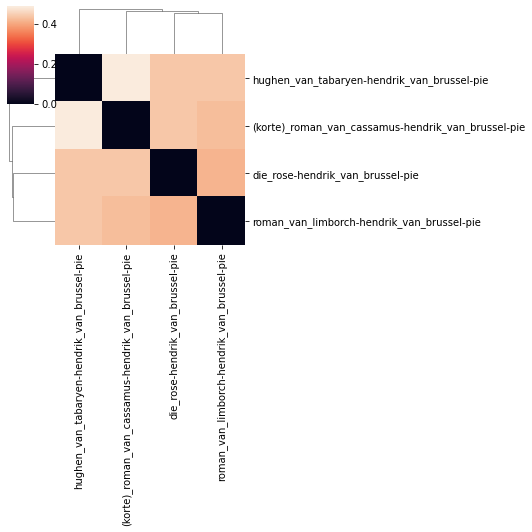

In [93]:
seaborn.clustermap(get_cluster_per_text(test_cluster_frame), figsize=(7.5, 7.5))

## Calibration for "*Lancelot-compilatie*"

Loading in the calibration corpus:

In [94]:
documents, authors, titles, file_names = load_directory('lancelot', 1698, no_proper_names=True)
authors, titles, file_names

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.15it/s]


(['onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onbekend',
  'onb

In [95]:
titles[38]

'arturs_doet-39'

In [96]:
documents[38]

'hij$pron(pers,3,sing) zegenen$v(fin,past,lex) en$conj(coord) kruisen$v(fin,past,lex) hij$pron(pers,3,sing) zoetelijk$adv(gener)/ en$conj(coord) zeggen$v(fin,past,lex) ai$interj() heer$n(sing) van$adp() hemelrijk$n(sing)/ die$pron(rel) ik$pron(pers,1,sing) hebben$v(fin,pres,aux_cop) togen$v(participle,past) en$conj(coord) geven$v(participle,past)/ veel$num(indef) eren$n(sing) in$adp() dit$pron(dem) aards$adj() leven$n(sing)/ sident$adv(gener) dat$conj(subord) ik$pron(pers,1,sing) eerst$adv(gener) dragen$v(fin,past,lex) kroon$n(sing)/ en$conj(coord) het$pron(pers,3,sing) ik$pron(pers,1,sing) vallen$v(fin,past,lex) zo$adv(resum) schoon$adj()/ dat$conj(subord) ik$pron(pers,1,sing) de$adp() te$art(def) land$n(sing) komen$v(fin,past,lex) de$art(def) en$conj(coord) eer$n(sing)/ te$adp() houden$v(infin) dat$pron(dem) zijn$v(fin,past,aux_cop) bij$adp() gij$pron(poss) heer$n(sing)/ en$conj(coord) al$adv(gener) bij$adp() de$art(def) genade$n(sing) van$adp() gij$pron(pers,2,sing)/ zoet$adj() heer

Creating a data frame with all of the information regarding the text segments:

In [97]:
dev = {'title': titles, 'author': authors, 'file': file_names, 'segments': documents}
dev = pd.DataFrame(data=dev)
dev

,title,author,file,segments
0,arturs_doet-1,onbekend,arturs_doet-onbekend-pie,"men$pron(indef) zeggen$v(fin,pres,lex) dat$con..."
1,arturs_doet-2,onbekend,arturs_doet-onbekend-pie,in$adp() zulk$pron(dem) zin$n(sing)/ dat$conj(...
2,arturs_doet-3,onbekend,arturs_doet-onbekend-pie,"zijn$v(fin,past,aux_cop) te$pron(dem) die$adp(..."
3,arturs_doet-4,onbekend,arturs_doet-onbekend-pie,"en$conj(coord) X zijn$v(fin,pres,aux_cop) over..."
4,arturs_doet-5,onbekend,arturs_doet-onbekend-pie,"klaar$adj()/ toen$adv(dem) spreken$v(fin,past,..."
...,...,...,...,...
301,wrake_van_ragisel-8,onbekend,wrake_van_ragisel-onbekend-pie,"zien$v(fin,past,aux_cop) toe$pronadv(prep)/ en..."
302,wrake_van_ragisel-9,onbekend,wrake_van_ragisel-onbekend-pie,"kasteel$n(sing)/ heten+hij+men$v(fin,past,lex)..."
303,wrake_van_ragisel-10,onbekend,wrake_van_ragisel-onbekend-pie,die$pron(rel) zijn$pron(poss) zwaard$n(sing) k...
304,wrake_van_ragisel-11,onbekend,wrake_van_ragisel-onbekend-pie,mede$pronadv(prep) de$te de$art(def) stad$n(si...


Obtaining the amount of segments for each text:

In [98]:
for file in dev['file'].unique():
    print(file)
    print(len(dev[dev["file"] == file]))

arturs_doet-onbekend-pie
46
lanceloet_en_het_hert_met_de_witte_voet-onbekend-pie
2
queeste_van_den_grale-onbekend-pie
39
roman_van_den_riddere_metter_mouwen-onbekend-pie
14
roman_van_lancelot-onbekend-pie
133
roman_van_moriaen-onbekend-pie
16
roman_van_perchevael-onbekend-pie
19
roman_van_torec-onbekend-pie
13
walewein_ende_keye-onbekend-pie
12
wrake_van_ragisel-onbekend-pie
12


Features for the vectorizer:

In [99]:
rhyme_words_all = {'use_idf': False,
          'max_features':100,
          'analyzer': 'word',
          'token_pattern': r"([^ ]*)\/",
#           'min_df': 2,
          'norm': 'l1', 
          'ngram_range': (1, 1)}

In [100]:
rhyme_vectorizer = TfidfVectorizer(**rhyme_words_all)

Fitting and tranforming:

In [101]:
dev_X = rhyme_vectorizer.fit_transform(dev['segments']).toarray()

The number of segments in the first spot and the amount of features in the second spot:

In [102]:
dev_X.shape

(306, 100)

Using the "Calibrator":

In [103]:
calibrator = Calibrator(iters=200, rnd_prop=0.5) # 200 iterations based on 50% of the features

In [104]:
result_SA, result_DA, clustermap = calibrator.calculate_distance(dev, dev_X)
result_SA, result_DA 

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [46:06<00:00, 13.83s/it]


([0.39409853031352166,
  0.43118973323069976,
  0.3731118627468119,
  0.38232071079974755,
  0.44084198187840207,
  0.40860739306813043,
  0.38268819529980797,
  0.3809058845414725,
  0.40808202081317424,
  0.4175275561994449,
  0.41476768484691645,
  0.4110296071094573,
  0.4899810469961082,
  0.44275032959120003,
  0.41717582882570453,
  0.4743097541458542,
  0.40785730870467674,
  0.4081829760854787,
  0.402571318474461,
  0.406545920482393,
  0.4200069977659442,
  0.491443746682776,
  0.4280459167944658,
  0.4676429752071447,
  0.4141761208081793,
  0.3838066421407409,
  0.5203831142037815,
  0.4736332026071725,
  0.391014676821154,
  0.38779232979682116,
  0.41473623876088817,
  0.47784634814762433,
  0.4226093224956585,
  0.45760615170801217,
  0.423084349375457,
  0.41676126521714835,
  0.41465556142648446,
  0.40888870887225476,
  0.4247729571636725,
  0.4926249887115391,
  0.4487110773679486,
  0.4830672594111349,
  0.4248476703790839,
  0.42280932537218613,
  0.41190467884519

The average distance (we actually calculate the DA distance here, do not mind the name of the variable):

In [105]:
avg_SA = sum(result_SA)/len(result_SA)
print(round(avg_SA, 4))

0.4251


The median distance:

In [106]:
print(statistics.median(result_SA))

0.41846547287125263


A boxplot with the distribution of the cosine distances between DA pairs (the model sees this as SA pairs, since the author names are the same (onbekend), that is why the label of the bowplot is differrent):

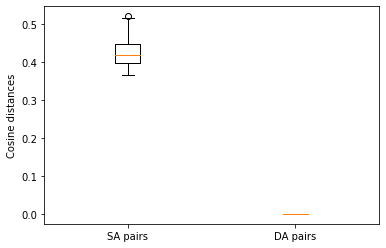

In [107]:
fig, ax = plt.subplots()
ax.boxplot([result_SA, result_DA])
ax.set(xticklabels=('SA pairs', 'DA pairs'), ylabel='Cosine distances');

A clustermap of the works and their distances. 

In [108]:
cluster_frame = pd.DataFrame(data=clustermap)
cluster_frame = cluster_frame.set_index(dev['file'])
cluster_frame.set_axis(dev["file"].values.tolist(), axis=1, inplace=True)
cluster_frame

,arturs_doet-onbekend-pie,arturs_doet-onbekend-pie,arturs_doet-onbekend-pie,arturs_doet-onbekend-pie,arturs_doet-onbekend-pie,arturs_doet-onbekend-pie,arturs_doet-onbekend-pie,arturs_doet-onbekend-pie,arturs_doet-onbekend-pie,arturs_doet-onbekend-pie,...,wrake_van_ragisel-onbekend-pie,wrake_van_ragisel-onbekend-pie,wrake_van_ragisel-onbekend-pie,wrake_van_ragisel-onbekend-pie,wrake_van_ragisel-onbekend-pie,wrake_van_ragisel-onbekend-pie,wrake_van_ragisel-onbekend-pie,wrake_van_ragisel-onbekend-pie,wrake_van_ragisel-onbekend-pie,wrake_van_ragisel-onbekend-pie
file,,,,,,,,,,,,,,,,,,,,,
arturs_doet-onbekend-pie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.524014,0.503769,0.608264,0.551280,0.520625,0.621427,0.646444,0.626722,0.527684,0.517875
arturs_doet-onbekend-pie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.419276,0.499217,0.490144,0.581323,0.570091,0.555744,0.604781,0.572045,0.496933,0.545558
arturs_doet-onbekend-pie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.313726,0.408331,0.372056,0.341321,0.346444,0.351086,0.319026,0.384239,0.381149,0.332953
arturs_doet-onbekend-pie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.310816,0.357635,0.313903,0.363026,0.448890,0.324964,0.346504,0.373917,0.358545,0.377384
arturs_doet-onbekend-pie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.503001,0.550544,0.462844,0.391027,0.430472,0.434681,0.437956,0.479842,0.495842,0.452802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wrake_van_ragisel-onbekend-pie,0.621427,0.555744,0.351086,0.324964,0.434681,0.432698,0.355514,0.406687,0.409235,0.511641,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
wrake_van_ragisel-onbekend-pie,0.646444,0.604781,0.319026,0.346504,0.437956,0.389727,0.390556,0.492631,0.382738,0.430996,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
wrake_van_ragisel-onbekend-pie,0.626722,0.572045,0.384239,0.373917,0.479842,0.413705,0.382118,0.467627,0.367941,0.467694,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [109]:
get_cluster_per_text (cluster_frame)

,arturs_doet-onbekend-pie,lanceloet_en_het_hert_met_de_witte_voet-onbekend-pie,queeste_van_den_grale-onbekend-pie,roman_van_den_riddere_metter_mouwen-onbekend-pie,roman_van_lancelot-onbekend-pie,roman_van_moriaen-onbekend-pie,roman_van_perchevael-onbekend-pie,roman_van_torec-onbekend-pie,walewein_ende_keye-onbekend-pie,wrake_van_ragisel-onbekend-pie
arturs_doet-onbekend-pie,0.000000,0.504138,0.406758,0.441360,0.401607,0.522926,0.430062,0.430415,0.413472,0.416833
lanceloet_en_het_hert_met_de_witte_voet-onbekend-pie,0.504138,0.000000,0.492756,0.453864,0.476846,0.461284,0.477707,0.479064,0.441537,0.459350
queeste_van_den_grale-onbekend-pie,0.406758,0.492756,0.000000,0.464789,0.348197,0.552736,0.438503,0.431499,0.434017,0.431395
roman_van_den_riddere_metter_mouwen-onbekend-pie,0.441360,0.453864,0.464789,0.000000,0.463722,0.474791,0.377093,0.374463,0.369657,0.365239
roman_van_lancelot-onbekend-pie,0.401607,0.476846,0.348197,0.463722,0.000000,0.548188,0.429615,0.439659,0.441470,0.428087
roman_van_moriaen-onbekend-pie,0.522926,0.461284,0.552736,0.474791,0.548188,0.000000,0.485083,0.533110,0.486913,0.501701
roman_van_perchevael-onbekend-pie,0.430062,0.477707,0.438503,0.377093,0.429615,0.485083,0.000000,0.368380,0.362592,0.332750
roman_van_torec-onbekend-pie,0.430415,0.479064,0.431499,0.374463,0.439659,0.533110,0.368380,0.000000,0.318944,0.327286
walewein_ende_keye-onbekend-pie,0.413472,0.441537,0.434017,0.369657,0.441470,0.486913,0.362592,0.318944,0.000000,0.328205
wrake_van_ragisel-onbekend-pie,0.416833,0.459350,0.431395,0.365239,0.428087,0.501701,0.332750,0.327286,0.328205,0.000000


C:\Users\carol\anaconda3\lib\site-packages\seaborn\matrix.py:619: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


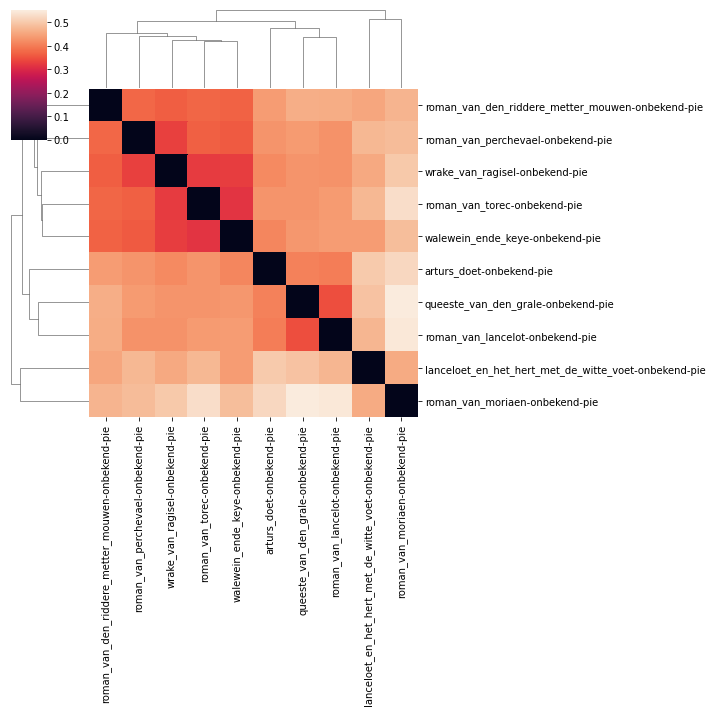

In [110]:
seaborn.clustermap(get_cluster_per_text (cluster_frame), figsize=(10,10))

Obtaining extra statistics again

In [111]:
dev["unique_rhyme"] = dev['segments'].apply(get_unique_rhyme)
stat = dev.groupby('file').agg(sum)
stat['unique_rhyme_amount'] = stat['unique_rhyme'].apply(number_unique_rhyme)
stat

,title,author,segments,unique_rhyme,unique_rhyme_amount
file,,,,,
arturs_doet-onbekend-pie,arturs_doet-1arturs_doet-2arturs_doet-3arturs_...,onbekendonbekendonbekendonbekendonbekendonbeke...,"men$pron(indef) zeggen$v(fin,pres,lex) dat$con...","[voren, minne, schoonheid, deze, aannemen, ver...",1303
lanceloet_en_het_hert_met_de_witte_voet-onbekend-pie,lanceloet_en_het_hert_met_de_witte_voet-1lance...,onbekendonbekend,"avontuur$art(def) de$n(sing) vertellen$v(fin,p...","[voren, minne, dwars, nagaan, lof, zonneschijn...",269
queeste_van_den_grale-onbekend-pie,queeste_van_den_grale-1queeste_van_den_grale-2...,onbekendonbekendonbekendonbekendonbekendonbeke...,een$art(indef) schoon$adj() avontuur$n(sing) h...,"[graal, deze, verstaan, waart, spreken, zaal, ...",1054
roman_van_den_riddere_metter_mouwen-onbekend-pie,roman_van_den_riddere_metter_mouwen-1roman_van...,onbekendonbekendonbekendonbekendonbekendonbeke...,"wij$pron(pers,1,plu) vertellen$v(fin,pres,lex)...","[deze, lijk, vloer, verstaan, voor, bezien, mi...",841
roman_van_lancelot-onbekend-pie,roman_van_lancelot-1roman_van_lancelot-2roman_...,onbekendonbekendonbekendonbekendonbekendonbeke...,god$n(sing) die$art(def) maker$n(sing) zijn$v(...,"[voren, minne, hoofd, deze, geloven, verstaan,...",1723
roman_van_moriaen-onbekend-pie,roman_van_moriaen-1roman_van_moriaen-2roman_va...,onbekendonbekendonbekendonbekendonbekendonbeke...,"wij$pron(pers,1,plu) maken$v(fin,pres,lex) kon...","[voren, graal, kond, kanunbeer, verstaan, lof,...",967
roman_van_perchevael-onbekend-pie,roman_van_perchevael-1roman_van_perchevael-2ro...,onbekendonbekendonbekendonbekendonbekendonbeke...,"avontuur$art(def) de$n(sing) gewagen$v(fin,pre...","[voren, minne, deze, wijl, dogen, verstaan, lo...",963
roman_van_torec-onbekend-pie,roman_van_torec-1roman_van_torec-2roman_van_to...,onbekendonbekendonbekendonbekendonbekendonbeke...,"de$art(def) avontuur$n(sing) doen$v(fin,pres,l...","[deze, kond, verstaan, bezweren, lof, daarnaar...",794
walewein_ende_keye-onbekend-pie,walewein_ende_keye-1walewein_ende_keye-2walewe...,onbekendonbekendonbekendonbekendonbekendonbeke...,"de$art(def) avontuur$n(sing) doen$v(fin,pres,l...","[voren, deze, kond, lof, gezel, daarnaar, wijs...",737


In [112]:
dev["rhyme"] = dev['segments'].apply(get_verse)
stat = dev.groupby('file').agg(sum)
stat

,rhyme
file,
arturs_doet-onbekend-pie,12865
lanceloet_en_het_hert_met_de_witte_voet-onbekend-pie,580
queeste_van_den_grale-onbekend-pie,10911
roman_van_den_riddere_metter_mouwen-onbekend-pie,3854
roman_van_lancelot-onbekend-pie,36735
roman_van_moriaen-onbekend-pie,4610
roman_van_perchevael-onbekend-pie,5321
roman_van_torec-onbekend-pie,3575
walewein_ende_keye-onbekend-pie,3385


# Verification (based on the previous model)

Applying the verification to the possible oeuvre of Hendrik van Brussel:

In [113]:
test_directory = 'hendrik'

test_documents, test_authors, test_titles, test_file_names = load_directory(test_directory, 1698, no_proper_names=True)
test_documents, test_authors, test_titles, test_file_names

test = {'title': test_titles, 'author': test_authors, 'file': test_file_names, 'segments': test_documents}
test = pd.DataFrame(data=test)
test

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.11it/s]


,title,author,file,segments
0,(korte)_roman_van_cassamus-1,hendrik_van_brussel,(korte)_roman_van_cassamus-hendrik_van_brussel...,X/ na$adp() die$pron(dem) dat$conj(subord) de$...
1,(korte)_roman_van_cassamus-2,hendrik_van_brussel,(korte)_roman_van_cassamus-hendrik_van_brussel...,op$adp() een$art(indef) rivier$n(sing)/ en$con...
2,(korte)_roman_van_cassamus-3,hendrik_van_brussel,(korte)_roman_van_cassamus-hendrik_van_brussel...,"negeen$pron(indef) ontzeggen$v(fin,past,lex)/ ..."
3,(korte)_roman_van_cassamus-4,hendrik_van_brussel,(korte)_roman_van_cassamus-hendrik_van_brussel...,"te+wij+waart$adp()+pron(pers,1,plu)+adp() kome..."
4,(korte)_roman_van_cassamus-5,hendrik_van_brussel,(korte)_roman_van_cassamus-hendrik_van_brussel...,kracht$n(sing) daar$pronadv(dem) mede$pronadv(...
...,...,...,...,...
125,roman_van_limborch-69,hendrik_van_brussel,roman_van_limborch-hendrik_van_brussel-pie,"ik$pron(pers,1,sing) mogen$v(fin,pres,aux_cop)..."
126,roman_van_limborch-70,hendrik_van_brussel,roman_van_limborch-hendrik_van_brussel-pie,de$art(def) weg$n(sing) iet$pron(indef) togen$...
127,roman_van_limborch-71,hendrik_van_brussel,roman_van_limborch-hendrik_van_brussel-pie,"groot$adj() plein$n(sing) zij$pron(pers,3,plu)..."
128,roman_van_limborch-72,hendrik_van_brussel,roman_van_limborch-hendrik_van_brussel-pie,"komen$v(participle,pres) verzien$v(infin)/ en$..."


In [114]:
test_X = rhyme_vectorizer.transform(test['segments']).toarray() # use the fitted vectorizer

test_result_SA, test_result_DA, test_clustermap = calibrator.calculate_distance(test, test_X) # use the calibrator defined previously
test_result_SA, test_result_DA

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [07:50<00:00,  2.35s/it]


([0.48281452994639806,
  0.45323849995977017,
  0.4429909653361109,
  0.3726039386963443,
  0.3657168263661999,
  0.44618256167952397,
  0.42730600400431473,
  0.36624751140232514,
  0.45800514116099045,
  0.4614561123499163,
  0.36233567270271233,
  0.3699052203183791,
  0.39067187140621024,
  0.36642172560691616,
  0.36417887488467887,
  0.4220622067066467,
  0.5077324083698667,
  0.37327343608076435,
  0.3734438149982804,
  0.3699985382292621,
  0.379508467757899,
  0.4545703680989724,
  0.3583805407131204,
  0.44881614159853345,
  0.48919888788691046,
  0.4972042387033134,
  0.3787757537930129,
  0.37038042569123947,
  0.3750214077192211,
  0.4659004640436934,
  0.47674437192466645,
  0.526232782810891,
  0.49431586717723797,
  0.38074004896159125,
  0.3705421314751671,
  0.3810002442035908,
  0.4661296439865462,
  0.4264109829365021,
  0.49937864711851176,
  0.36588658826231024,
  0.464335587831671,
  0.36464917138476155,
  0.3728585827079892,
  0.38233441150323966,
  0.3639347544

The average distances (we want to examine whether the works were written by the same author, so we only calculate one value now. Do not mind the names of the variables):

In [115]:
test_avg_SA = sum(test_result_SA)/len(test_result_SA)
print(round(test_avg_SA, 4))
test_avg_DA = sum(test_result_DA)/len(test_result_DA)
print(round(test_avg_DA, 4))

0.4154
0.0


The median distances:

In [116]:
print(statistics.median(test_result_SA))
print(statistics.median(result_SA))
print(statistics.median(result_DA))

0.3881434626267648
0.41846547287125263
0.0


A boxplot with the distribution of the cosine distances:

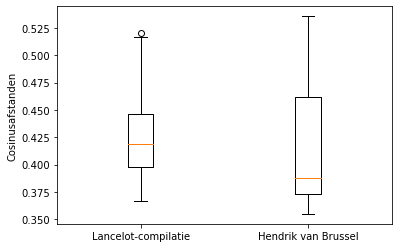

In [117]:
fig, ax = plt.subplots()
ax.boxplot([result_SA, test_result_SA])
ax.set(xticklabels=('Lancelot-compilatie', 'Hendrik van Brussel'), ylabel='Cosinusafstanden');

Creating a clustermap of the works and their distances. 

In [118]:
test_cluster_frame = pd.DataFrame(data=test_clustermap)
test_cluster_frame = test_cluster_frame.set_index(test['file'])
test_cluster_frame.set_axis(test["file"].values.tolist(), axis=1, inplace=True)
test_cluster_frame

,(korte)_roman_van_cassamus-hendrik_van_brussel-pie,(korte)_roman_van_cassamus-hendrik_van_brussel-pie,(korte)_roman_van_cassamus-hendrik_van_brussel-pie,(korte)_roman_van_cassamus-hendrik_van_brussel-pie,(korte)_roman_van_cassamus-hendrik_van_brussel-pie,(korte)_roman_van_cassamus-hendrik_van_brussel-pie,die_rose-hendrik_van_brussel-pie,die_rose-hendrik_van_brussel-pie,die_rose-hendrik_van_brussel-pie,die_rose-hendrik_van_brussel-pie,...,roman_van_limborch-hendrik_van_brussel-pie,roman_van_limborch-hendrik_van_brussel-pie,roman_van_limborch-hendrik_van_brussel-pie,roman_van_limborch-hendrik_van_brussel-pie,roman_van_limborch-hendrik_van_brussel-pie,roman_van_limborch-hendrik_van_brussel-pie,roman_van_limborch-hendrik_van_brussel-pie,roman_van_limborch-hendrik_van_brussel-pie,roman_van_limborch-hendrik_van_brussel-pie,roman_van_limborch-hendrik_van_brussel-pie
file,,,,,,,,,,,,,,,,,,,,,
(korte)_roman_van_cassamus-hendrik_van_brussel-pie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.510296,0.464057,0.405926,0.415100,...,0.284227,0.325913,0.264523,0.297491,0.395946,0.505823,0.288506,0.225927,0.303096,0.340222
(korte)_roman_van_cassamus-hendrik_van_brussel-pie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.448685,0.397762,0.351428,0.454959,...,0.257564,0.253346,0.242426,0.311063,0.385576,0.360167,0.245224,0.177175,0.254715,0.301599
(korte)_roman_van_cassamus-hendrik_van_brussel-pie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.586696,0.447220,0.408720,0.415097,...,0.320653,0.282956,0.286980,0.368670,0.413973,0.524567,0.308877,0.155575,0.316002,0.378793
(korte)_roman_van_cassamus-hendrik_van_brussel-pie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.590532,0.489351,0.385152,0.425951,...,0.320705,0.346271,0.340679,0.325064,0.435300,0.515177,0.276143,0.192606,0.334903,0.361971
(korte)_roman_van_cassamus-hendrik_van_brussel-pie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.426189,0.337552,0.392882,0.341988,...,0.296334,0.356243,0.306147,0.264237,0.340950,0.542444,0.379979,0.347077,0.295040,0.213582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
roman_van_limborch-hendrik_van_brussel-pie,0.505823,0.360167,0.524567,0.515177,0.542444,0.481900,0.529758,0.454140,0.411854,0.531365,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
roman_van_limborch-hendrik_van_brussel-pie,0.288506,0.245224,0.308877,0.276143,0.379979,0.453110,0.502256,0.348737,0.366511,0.570238,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
roman_van_limborch-hendrik_van_brussel-pie,0.225927,0.177175,0.155575,0.192606,0.347077,0.407603,0.518724,0.365601,0.411033,0.468257,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


C:\Users\carol\anaconda3\lib\site-packages\seaborn\matrix.py:619: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


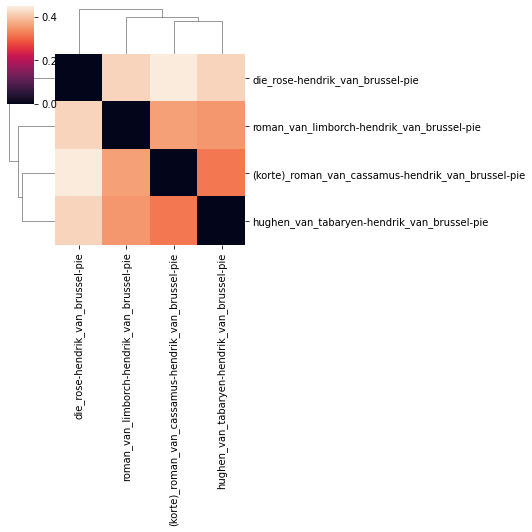

In [119]:
seaborn.clustermap(get_cluster_per_text(test_cluster_frame), figsize=(7.5, 7.5))